### Density Estimation 

- Following Manski et al.(2009)
- Three cases 
   - case 1. 3+ intervales with positive probabilities, to be fitted with a generalized beta distribution
   - case 2. exactly 2 adjacent intervals with positive probabilities, to be fitted with a triangle distribution 
   - case 3. one interval only, to be fitted with a uniform distribution

In [2]:
from scipy.stats import gamma
from scipy.stats import beta 
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
import pandas as pd

### Case 1. Generalized Beta Distribution

In [3]:
def GeneralizedBetaEst(bin,probs):
    """
    This fits a histogram with positive probabilities in at least 3 bins to a generalized beta distribution.
    Depending on if there is open-ended bin on either side with positive probability, 
       the estimator decides to estimate 2 or 4 parameters, respectively. 
       
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
                 
    returns
    -------
    moments:  ndarray of 2 or 4  
              2:  alpha and beta 
              4:  alpha, beta, lb, ub, e.g. lb=0 and ub=1 for a standard beta distribution
    """
    # n+1 bins and n probs, both are arrays
    if sum([probs[i]>0 for i in range(len(bin)-1)])<3:
        print("Warning: at least three bins with positive probs are needed")
        para_est=[]
    if sum(probs)!=1:
        print("probs need to sum up to 1")
        para_est=[]
    else:
        cdf = np.cumsum(probs)
        pprob=[i for i in range(len(bin)-1) if probs[i]>0]
        lb=bin[min(pprob)]
        print("lower bound is "+str(lb))
        ub=bin[max(pprob)+1]
        print("upper bound is "+str(ub))
        x0_2para = (2,1)
        x0_4para = (2,1,0,1) 
        def distance2para(paras2): # if there is no open-ended bin with positive probs 
            a,b=paras2
            distance= sum((beta.cdf(bin[1:],a,b,loc=lb,scale=ub-lb)-cdf)**2)
            return distance
        def distance4para(paras4): # if either on the left or right side one open-ended bin is with postive probs
            a,b,lb,ub=paras4
            distance= sum((beta.cdf(bin[1:],a,b,loc=lb,scale=ub-lb)-cdf)**2)
            return distance
        if lb==bin[0] and ub==bin[-1]:
            para_est = minimize(distance4para,x0_4para,method='CG')['x']
        else:
            para_est = minimize(distance2para,x0_2para,method='CG')['x']
        return para_est   # could be 2 or 4 parameters 

In [4]:
def GeneralizedBetaStats(alpha,beta,lb,ub):
    """
    This function computes the moments of a generalized beta distribution, mean and variance for now. 
    
    parameters
    ----------
    alpha, beta, lb, ub: floats 
    
    returns
    -------
    dict:  2 keys
           mean, float 
           variance, float 
    """
    # lb=0 and ub=1 for a standard beta distribution
    mean = lb + (ub-lb)*alpha/(alpha+beta)
    var = (ub-lb)**2*alpha*beta/((alpha+beta)**2*(alpha+beta+1))
    return {"mean": mean,"variance":var}

### Case 2. Isosceles Triangle distribution

Two adjacent intervales $[a,b]$,$[b,c]$ are assigned probs $\alpha$ and $1-\alpha$, respectively. In the case of $\alpha<1/2$, we need to solve parameter $t$ such that $[b-t,c]$ is the interval of the distribution. Denote the height of the trangle distribution $h$. Then following two restrictions need to satisfy

\begin{eqnarray}
\frac{t^2}{t+c-b} h = \alpha \\
(t+(c-b))h = 2
\end{eqnarray}

The two equations can solve $t$ and $h$

$$\frac{t^2}{(t+c-b)^2}=\alpha$$

$$t^2 = \alpha t^2 + 2\alpha t(c-b) + \alpha(c-b)^2$$

$$(1-\alpha) t^2 - 2\alpha(c-b) t - \alpha(c-b)^2=0$$

$$\implies t =\frac{2\alpha(c-b)+\sqrt{4\alpha^2(c-b)^2+4(1-\alpha)\alpha(c-b)^2}}{2(1-\alpha)} = \frac{\alpha(c-b)+(c-b)\sqrt{\alpha}}{(1-\alpha)}$$

$$\implies h = \frac{2}{t+c-b}$$


In [5]:
def TriangleEst(bin,probs):
    """
    The function fits histograms with exactly two adjacent 
       bins with positive probabilitie to a triangular distribution.
    It genetes the bounds of the isoceles triangle distribution. 
    
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    --------
    dict: 3 keys
          lb: float, left bound 
          ub: float, right bound
          h:  float, height of the triangle
    
    """
    if sum([probs[i]>0 for i in range(len(bin)-1)])==2:
        print("There are two bins with positive probs")
        pprobadj = [i for i in range(1,len(bin)-3) if probs[i]>0 and probs[i+1]>0]   # from 1 to -3 bcz excluding the open-ended on the left/right
        if sum(pprobadj)>0:
            print('The two intervals are adjacent and not open-ended')
            min_i = min(pprobadj)
            #print(min_i)
            #print(probs[min_i])
            #print(probs[min_i+1])
            #print(pprobadj[0])
            #print(pprobadj[0]+2)
            #print(probs[min_i] > probs[min_i+1])
            #print(bin[pprobadj[0]])
            #print(bin[pprobadj[0]+2])
            if probs[min_i] > probs[min_i+1]:
                alf = probs[min_i+1]
                lb = bin[pprobadj[0]]
                scl = bin[pprobadj[0]+1]-bin[pprobadj[0]]
                t = scl*(alf/(1-alf) +np.sqrt(alf)/(1-alf))
                ub = bin[pprobadj[0]+1]+t 
                h = 2/(t+bin[pprobadj[0]+1]-bin[pprobadj[0]])
            if probs[min_i] < probs[min_i+1]:
                alf = probs[min_i]
                ub = bin[pprobadj[0]+2]
                scl = bin[pprobadj[0]+2]-bin[pprobadj[0]+1]
                t = scl*(alf/(1-alf) + np.sqrt(alf)/(1-alf))
                lb = bin[pprobadj[0]+1]-t  
                h = 2/(t+bin[pprobadj[0]+2]-bin[pprobadj[0]+1])
            if probs[min_i] == probs[min_i+1]:
                ub=bin[pprobadj[0]]
                lb=bin[pprobadj[0]+2]
                h = 2/(ub-lb)
        else:
            lb = []
            ub = []
            h = []
            print('Warning: the two intervals are not adjacent or are open-ended')
    return {'lb':lb,'ub':ub,"height":h}

#### pdf of a triangle distribution

\begin{eqnarray}
f(x)= & 1/2(x-lb) \frac{x-lb}{(ub+lb)/2}h \quad \text{if } x <(lb+ub)/2 \\
& = 1/2(ub-x) \frac{ub-x}{(ub+lb)/2}h \quad \text{if } x \geq(lb+ub)/2
\end{eqnarray}

\begin{eqnarray}
& Var(x) & = \int^{ub}_{lb} (x-(lb+ub)/2)^2 f(x) dx \\
& & = 2 \int^{(ub+lb)/2}_{lb} (x-(lb+ub)/2)^2 (x-lb) \frac{x-lb}{(ub+lb)/2}h dx
\end{eqnarray}



In [6]:
def TriangleStats(lb,ub):
    """
    parameters
    ----------
    lb and ub:  float, left and right bounds of the triangle distribution
    
    returns
    -------
    dict:  2 keys for now
           mean: estimated mean
           variance: estimated variance
    """
    
    mean = (lb+ub)/2
    var = (lb**2+ub**2+(lb+ub)**2/4-lb*(lb+ub)/2-ub*(lb+ub)/2-lb*ub)/18
    return {"mean":mean,"variance":var}

### Case 3. Uniform Distribution

In [7]:
def UniformEst(bin,probs):
    """
    This function fits a histogram with only one bin of positive probability to a uniform distribution.
    
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    --------
    dict: 2 keys
          lb and ub, float. the left and right bounds of the uniform distribution
    """
    pprob=[i for i in range(len(bin)-1) if probs[i]>0]
    if len(pprob)==1:
        if pprob[0]!=0 and pprob[0]!=len(bin)-1:
            lb = bin[pprob[0]]
            ub = bin[pprob[0]+1]
        else:
            lb=[]
            ub=[]
    else:
        lb=[]
        ub=[]
    return {"lb":lb,"ub":ub}

In [8]:
def UniformStats(lb,ub):
    """
    The function computes the moment of a uniform distribution.
    
    parameters
    ----------
    lb and ub, floats, left and right bounds of uniform distribution
    
    returns
    --------
    dict:  2 keys for now
           mean: estimated mean
           variance: estimated variance 
    """
    
    if lb!=[] and ub!=[]:
        mean = (lb+ub)/2
        var = (ub-lb)**2/12
    else:
        mean=[]
        var=[]
    return {"mean":mean,"variance":var}

### Test using made-up data

In [9]:
## test 1: GenBeta Dist
sim_bins= np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs=np.array([0,0.2,0.5,0.3,0])
GeneralizedBetaEst(sim_bins,sim_probs)

lower bound is 0.2
upper bound is 1.0


array([2.08099415, 4.90193686])

In [10]:
## test 2: Triangle Dist
sim_bins2 = np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs2=np.array([0.2,0,0.8,0,0])
TriangleEst(sim_bins2,sim_probs2)

There are two bins with positive probs


{'lb': [], 'ub': [], 'height': []}

In [11]:
## test 3: Uniform Dist

sim_bins3 = np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs3=np.array([0,0,0,0,1])
UniformEst(sim_bins3,sim_probs3)

{'lb': 1.0, 'ub': 1.2}

### Test with simulated data from known distribution 
- we simulate data from a true beta distribution with known parameters
- then we estimate the parameters with our module and see how close it is with the true parameters 

lower bound is 0.0031609274617455567
upper bound is 0.9643378430558182


array([ 2.36363817,  3.74822512, -0.08075904,  1.14240754])

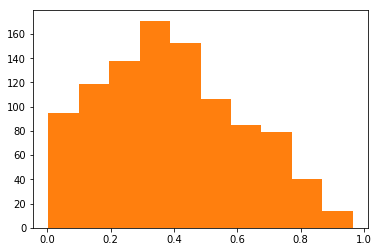

In [12]:
## simulate a generalized distribution
sim_n=1000
true_alpha,true_beta,true_loc,true_scale=1.4,2.2,0,1
sim_data = beta.rvs(true_alpha,true_beta,loc=true_loc,scale=true_scale,size=sim_n)
sim_bins2=plt.hist(sim_data)[1]
sim_probs2=plt.hist(sim_data)[0]/sim_n
sim_est=GeneralizedBetaEst(sim_bins2,sim_probs2)
sim_est

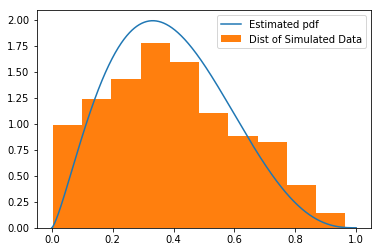

In [13]:
## plot the estimated generalized beta versus the histogram of simulated data drawn from a true beta distribution 
sim_x = np.linspace(true_loc,true_loc+true_scale,sim_n)
sim_pdf=beta.pdf(sim_x,sim_est[0],sim_est[1],loc=true_loc,scale=true_scale)
plt.plot(sim_x,sim_pdf,label='Estimated pdf')
plt.hist(sim_data,density=True,label='Dist of Simulated Data')
plt.legend(loc=0)

In [16]:
## This is the synthesized density estimation function
def SynDensityStat(bin,probs):
    """
    Synthesized density estimate module:
    It first detects the shape of histograms
    Then accordingly invoke the distribution-specific tool.
    
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    -------
    moments: dict with 2 keys (more to be added in future)
            mean: empty or float, estimated mean 
            variance:  empty or float, estimated variance 
    
    """
    if sum(probs)==1:
        print("probs sum up to 1")
        ## Beta distributions 
        if sum([probs[i]>0 for i in range(len(bin)-1)])>=3:
            print("at least three bins with positive probs")
            para_est=GeneralizedBetaEst(bin,probs)
            if len(para_est)==4:
                print('4 parameters')
                return GeneralizedBetaStats(para_est[0],para_est[1],para_est[2],para_est[3])
            if len(para_est)==2:
                print('2 parameters')
                return GeneralizedBetaStats(para_est[0],para_est[1],0,1)
        ## Triangle distributions
        if sum([probs[i]>0 for i in range(len(bin)-1)])==2:
            #print("There are two bins with positive probs")
            pprobadj = [i for i in range(1,len(bin)-3) if probs[i]>0 and probs[i+1]>0]   # from 1 to -3 bcz excluding the open-ended on the left/right
            if sum(pprobadj)>0:
                #print('The two intervals are adjacent and not open-ended')
                para_est=TriangleEst(bin,probs)
                return TriangleStats(para_est['lb'],para_est['ub'])
        if sum([probs[i]>0 for i in range(len(bin)-1)])==1:
            print('Only one interval with positive probs')
            para_est= UniformEst(bin,probs)
            print(para_est)
            return UniformStats(para_est['lb'],para_est['ub'])
        else:
            return {"mean":[],"variance":[]}
    else:
        return {"mean":[],"variance":[]}

In [17]:
## testing the synthesized estimator function using an arbitrary example created above
SynDensityStat(sim_bins2,sim_probs2)['variance']

probs sum up to 1
at least three bins with positive probs
lower bound is 0.0031609274617455567
upper bound is 0.9643378430558182
4 parameters


0.04989387287886408

In [43]:
### loading probabilistic data  
IndSPF=pd.read_stata('../SurveyData/SPF/individual/InfExpSPFProbIndQ.dta')   
# SPF inflation quarterly 
# 2 Inf measures: CPI and PCE
# 2 horizons: y-1 to y  and y to y+1

In [44]:
## survey-specific parameters 
nobs=len(IndSPF)
SPF_bins=np.array([-10,0,0.5,1,1.5,2,2.5,3,3.5,4,10])
print("There are "+str(len(SPF_bins)-1)+" bins in SPF")

There are 10 bins in SPF


In [46]:
##############################################
### attention: the estimation happens here!!!!!
###################################################

#IndSPF['PRCCPIMean0']='nan'   # CPI from y-1 to y 
#IndSPF['PRCCPIVar0']='nan'    
#IndSPF['PRCCPIMean1']='nan'  # CPI from y to y+1  
#IndSPF['PRCCPIVar1']='nan'
#IndSPF['PRCPCEMean0']='nan' # PCE from y-1 to y
#IndSPF['PRCPCEVar0']='nan'
#IndSPF['PRCPCEMean1']='nan' # PCE from y to y+1
#IndSPF['PRCPCEVar1']='nan'


## creating positions 
index  = IndSPF.index
columns=['PRCCPIMean0','PRCCPIVar0', 'PRCCPIMean1','PRCCPIVar1',
         'PRCPCEMean0','PRCPCEVar0','PRCPCEMean1','PRCPCEVar1']
IndSPF_moment_est = pd.DataFrame(index=index,columns=columns)

## Invoking the estimation

for i in range(nobs):
    print(i)
    ## take the probabilities (flip to the right order, normalized to 0-1)
    PRCCPI_y0 = np.flip(np.array([IndSPF.iloc[i,:]['PRCCPI'+str(n)]/100 for n in range(1,11)]))
    print(PRCCPI_y0)
    PRCCPI_y1 = np.flip(np.array([IndSPF.iloc[i,:]['PRCCPI'+str(n)]/100 for n in range(11,21)]))
    print(PRCCPI_y1)
    PRCPCE_y0 = np.flip(np.array([IndSPF.iloc[i,:]['PRCPCE'+str(n)]/100 for n in range(1,11)]))
    print(PRCCPI_y0)
    PRCPCE_y1 = np.flip(np.array([IndSPF.iloc[i,:]['PRCPCE'+str(n)]/100 for n in range(11,21)]))
    print(PRCCPI_y1)
    if not np.isnan(PRCCPI_y0).any():
        stats_est=SynDensityStat(SPF_bins,PRCCPI_y0)
        if stats_est.size>0:
            IndSPF_moment_est['PRCCPIMean0'][i]=stats_est['mean']
            print(stats_est['mean'])
            IndSPF_moment_est['PRCCPIVar0'][i]=stats_est['variance']
            print(stats_est['variance'])
    if not np.isnan(PRCCPI_y1).any():
        stats_est=SynDensityStat(SPF_bins,PRCCPI_y1)
        if stats_est.size>0:
            print(stats_est['mean'])
            IndSPF_moment_est['PRCCPIMean1'][i]=stats_est['mean']
            print(stats_est['variance'])
            IndSPF_moment_est['PRCCPIVar1'][i]=stats_est['variance']
    if not np.isnan(PRCPCE_y0).any():
        if stats_est.size>0:
            stats_est=SynDensityStat(SPF_bins,PRCPCE_y0)
            print(stats_est['mean'])
            IndSPF_moment_est['PRCPCEMean0'][i]=stats_est['mean']
            print(stats_est['variance'])
            IndSPF_moment_est['PRCPCEVar0'][i]=stats_est['variance']
    if not np.isnan(PRCPCE_y1).any():
        if stats_est.size>0:
            stats_est=SynDensityStat(SPF_bins,PRCPCE_y1)
            print(stats_est['mean'])
            IndSPF_moment_est['PRCPCEMean1'][i]=stats_est['mean']
            print(stats_est['variance'])
            IndSPF_moment_est['PRCPCEVar1'][i]=stats_est['variance']

0
[0.  0.  0.  0.  0.  0.4 0.4 0.2 0.  0. ]
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  0. ]
[0.  0.  0.  0.  0.  0.4 0.4 0.2 0.  0. ]
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
2 parameters
0.42703989182291147
0.42703989182291147
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5339485560023147
0.04583340869330193
[]
[]
[]
[]
1
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
2
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
3
[0.  0.  0.  0.  0.  0.2 0.7 0.1 0.  0. ]
[0.  0.  0.  0.  0.  0.2 0.6 0.2 0.  0. ]
[0.  0.  0.  0.  0.  0.2 0.7 0.1 0.  0. ]
[0.  0.  0.  0.  0.  0.2 0.6 0.2 0.  0. ]
[]
[]
probs

0.09613088107781945
17
[0.   0.08 0.15 0.2  0.25 0.15 0.08 0.04 0.03 0.02]
[0.   0.05 0.12 0.2  0.25 0.15 0.12 0.05 0.03 0.03]
[0.   0.08 0.15 0.2  0.25 0.15 0.08 0.04 0.03 0.02]
[0.   0.05 0.12 0.2  0.25 0.15 0.12 0.05 0.03 0.03]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.17195690513025785
0.17195690513025785
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.18698028916834367
0.008162126303860462
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.17195690513025785
0.007964211401123182
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.18698028916834367
0.008162126303860462
18
[0.   0.   0.01 0.09 0.26 0.35 0.27 0.02 0.   0.  ]
[0.   0.   0.   0.01 0.18 0.31 0.33 0.16 0.01 0.  ]
[0.   0.   0.01 0.09 0.26 0.35 0.27 0.02 0.   0.  ]
[0.   0

2 parameters
0.6017018309813581
0.6017018309813581
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5788854069411699
0.03412809996362348
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.6070405488587255
0.03377076861705016
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5744694476016181
0.028682249662230486
30
[0.   0.   0.   0.1  0.25 0.35 0.2  0.1  0.   0.  ]
[0.   0.   0.   0.1  0.25 0.35 0.2  0.1  0.   0.  ]
[0.   0.   0.   0.1  0.25 0.35 0.2  0.1  0.   0.  ]
[0.   0.   0.   0.1  0.25 0.35 0.2  0.1  0.   0.  ]
[]
[]
[]
[]
[]
[]
[]
[]
31
[0.  0.  0.  0.  0.  0.7 0.2 0.1 0.  0. ]
[0.  0.  0.  0.  0.  0.8 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.  0.7 0.2 0.1 0.  0. ]
[0.  0.  0.  0.  0.  0.8 0.2 0.  0.  0. ]
[]
[]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and 

2 parameters
0.4570734424196047
0.02034190504129053
44
[0.   0.01 0.01 0.05 0.1  0.33 0.33 0.1  0.05 0.02]
[0.01 0.01 0.02 0.08 0.13 0.25 0.25 0.13 0.08 0.04]
[0.   0.01 0.01 0.05 0.1  0.33 0.33 0.1  0.05 0.02]
[0.01 0.01 0.02 0.08 0.13 0.25 0.25 0.13 0.08 0.04]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.2516968092811563
0.2516968092811563
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.4962758621195955
0.6478894425426965
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.2285973704775865
0.6604830055864892
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.2284107493069167
0.7498792382797103
45
[0.  0.  0.  0.1 0.4 0.4 0.1 0.  0.  0. ]
[0.   0.   0.   0.05 0.4  0.4  0.15 0.   0.   0.  ]
[0.  0.  0.  0.1 0.4 0.4 0.1 0.  0.  0. ]


4 parameters
2.5540571570034527
0.04675292158404008
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.2957596007252143
0.16120648151976955
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.2957596007252143
0.16120648151976955
61
[0.   0.   0.   0.   0.1  0.35 0.4  0.15 0.   0.  ]
[0.   0.   0.   0.   0.1  0.35 0.3  0.25 0.   0.  ]
[0.   0.   0.   0.   0.1  0.35 0.4  0.15 0.   0.  ]
[0.   0.   0.   0.   0.1  0.35 0.3  0.25 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.5251241579954528
0.5251241579954528
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.5472539031386905
0.0549306621849621
62
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan

2 parameters
0.6136357974009093
0.025793089445609086
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49999898348212196
0.023594165543534745
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5649110135879677
0.029192072977766853
75
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
76
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
[0.  0.  0.  0.2 0.2 0.4 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
[0.  0.  0.  0.2 0.2 0.4 0.2 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49999536111579357
0.49999536111579357
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5316443804727131
0.06174047276556668
probs sum

2 parameters
0.46604885466652757
0.04583547859463797
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.39995807912179665
0.03684162413640891
87
[0.   0.   0.   0.   0.05 0.75 0.2  0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.75 0.1  0.   0.   0.  ]
[0.   0.   0.   0.   0.05 0.75 0.2  0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.75 0.1  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.552110134141557
0.552110134141557
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.48299007769422075
0.0193699681152821
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49997967141229693
0.016198196210665577
[]
[]
88
[0.  0.  0.  0.  0.  0.4 0.5 0.1 0.  0. ]
[0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
[0.  0.  0.  0.  0.  0.4 0.5 0.1 0.  0. ]
[0.  0.  

2 parameters
0.44476834387306785
0.44476834387306785
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.4758621196546787
0.03632544576354112
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.20246338063540698
0.012675843927217502
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.21105816274791045
0.013007581177235848
100
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
101
[0.   0.   0.   0.   0.05 0.5  0.45 0.   0.   0.  ]
[0.   0.   0.   0.   0.05 0.5  0.45 0.   0.   0.  ]
[0.   0.   0.   0.   0.05 0.5  0.45 0.   0.   0.  ]
[0.   0.   0.   0.   0.05 0.5  0.45 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.63

2 parameters
0.49997967141229693
0.49997967141229693
[]
[]
118
[0.   0.   0.02 0.06 0.1  0.3  0.25 0.15 0.1  0.02]
[0.   0.05 0.02 0.06 0.12 0.2  0.25 0.15 0.12 0.03]
[0.   0.   0.02 0.06 0.1  0.3  0.25 0.15 0.1  0.02]
[0.   0.05 0.02 0.06 0.12 0.2  0.25 0.15 0.12 0.03]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 10.0
2 parameters
0.22171338237866683
0.22171338237866683
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.26034933256064385
0.007598202129662496
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 10.0
2 parameters
0.21541070677254404
0.0058930731015190896
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.2497965438576273
0.007403333704256657
119
[0.   0.   0.   0.   0.35 0.42 0.21 0.02 0.   0.  ]
[0.   0.   0.   0.01 0.29 0.33 0.36 0.01 0.   0.  ]
[0.   0.   0.   0.

2 parameters
0.5159814824956075
0.02785879569439198
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.22014230881897548
0.0073647217485353945
130
[0.  0.  0.  0.  0.3 0.4 0.3 0.  0.  0. ]
[0.   0.   0.05 0.1  0.25 0.35 0.2  0.05 0.   0.  ]
[0.  0.  0.  0.  0.3 0.4 0.3 0.  0.  0. ]
[0.   0.   0.05 0.1  0.25 0.35 0.2  0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5000016564930286
0.5000016564930286
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5383709712183881
0.03311278795152217
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5834533897289274
0.04047268480620701
131
[0.   0.   0.   0.   0.05 0.2  0.4  0.25 0.1  0.  ]
[0.   0.   0.   0.   0.11 0.22 0.34 0.22 0.11 0.  ]
[0.   0.   0.   0.   0.05 0.2  0.4  0.25 0.1  0

2 parameters
0.4477027867801186
0.027442536376126342
145
[0.01 0.01 0.01 0.05 0.25 0.35 0.25 0.05 0.01 0.01]
[0.02 0.02 0.03 0.08 0.21 0.3  0.21 0.08 0.03 0.02]
[0.01 0.01 0.01 0.05 0.25 0.35 0.25 0.05 0.01 0.01]
[0.02 0.02 0.03 0.08 0.21 0.3  0.21 0.08 0.03 0.02]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.2340907227822795
2.2340907227822795
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.2340907227822795
0.28336967695354426
[]
[]
146
[0.   0.   0.   0.   0.05 0.45 0.45 0.05 0.   0.  ]
[0.   0.   0.   0.05 0.45 0.45 0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.05 0.45 0.45 0.05 0.   0.  ]
[0.   0.   0.   0.05 0.45 0.45 0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.49999973347073623
0.49999973347073623
probs sum up to 1
at least three bins with positive probs
low

4 parameters
2.241661255269879
0.12767013421377116
159
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
160
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
161
[0.   0.   0.   0.   0.3  0.65 0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.25 0.55 0.2  0.   0.   0.  ]
[0.   0.   0.   0.   0.3  0.65 0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.25 0.55 0.2  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.41802527861738764
0.41802527861738764
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.48345564578553296
0.03932735888030974
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0

2 parameters
0.41889217919503285
0.41889217919503285
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.40770380322435956
0.024928604066482684
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.44007768837761163
0.029559449375767655
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.4149200384702861
0.02887740454225812
173
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
probs sum up to 1
Only one interval with positive probs
{'lb': 2.0, 'ub': 2.5}
[]
[]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.041666666666666664
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.180189805014032
0.077

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


2 parameters
0.4999983888117568
0.013834495880680852
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.4999983888117568
0.013834495880680852
175
[0.   0.   0.   0.   0.01 0.98 0.01 0.   0.   0.  ]
[0.   0.   0.05 0.15 0.7  0.1  0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.01 0.98 0.01 0.   0.   0.  ]
[0.   0.   0.05 0.15 0.7  0.1  0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5006774017240861
0.5006774017240861
[]
[]
176
[0.   0.   0.   0.1  0.15 0.5  0.15 0.1  0.   0.  ]
[0.   0.05 0.1  0.15 0.4  0.15 0.1  0.05 0.   0.  ]
[0.   0.   0.   0.1  0.15 0.5  0.15 0.1  0.   0.  ]
[0.   0.05 0.1  0.15 0.4  0.15 0.1  0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.500001487633802
0.500001487633802
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


2 parameters
0.6000420717951156
0.03684152091257669
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.39995807912179665
0.03684162413640891
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.39995807912179665
0.03684162413640891
185
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.3 0.5 0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.3 0.5 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5339485560023147
0.5339485560023147
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.619966934940462
0.07984826872791824
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.180189805014032
0.07710969514083763
probs sum up to 1
There are two bins wi

2 parameters
0.4727584528320167
0.03461385893793222
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.4640898938501068
0.04845111821839369
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.4727584528320167
0.03461385893793222
198
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
[0.  0.  0.  0.2 0.6 0.2 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
[0.  0.  0.  0.2 0.6 0.2 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49997967141229693
0.49997967141229693
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49999536111579357
0.03337473449588551
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.041666666666666664
probs sum up to 1
There are two bins with positive

2 parameters
0.49999898348212196
0.49999898348212196
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5669964112927235
0.01897559504071396
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5329447837018215
0.02250029069585816
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5819652349847242
0.02111756487321453
213
[0.   0.   0.   0.05 0.14 0.25 0.3  0.15 0.08 0.03]
[0.   0.   0.   0.05 0.14 0.25 0.3  0.15 0.08 0.03]
[0.   0.   0.   0.05 0.14 0.25 0.3  0.15 0.08 0.03]
[0.   0.   0.   0.05 0.14 0.25 0.3  0.15 0.08 0.03]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0
2 parameters
-69.98106437076153
-69.98106437076153
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0
2 parameters
-69.98106437076153
-574.546096514

2 parameters
0.24381833121164495
0.009260033583436085
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.22014230881897548
0.0073647217485353945
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.24381833121164495
0.009260033583436085
224
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
225
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
226
[0.018 0.018 0.02  0.046 0.092 0.137 0.184 0.183 0.137 0.165]
[0.018 0.018 0.02  0.046 0.092 0.137 0.184 0.183 0.137 0.165]
[0.018 0.018 0.02  0.046 0.092 0.137 0.184 0.183 0.137 0.165]
[0.018 0.018 0.02  0.046 0.092 0.137 0.184 0.183 0.137 0.165]
probs sum up to 1
at least three bins with posi

2 parameters
0.49999536111579357
0.49999536111579357
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.4674728775171327
0.032356185211528464
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.041666666666666664
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.259463815113608
0.09613088107781945
242
[0.   0.   0.02 0.02 0.04 0.07 0.22 0.24 0.23 0.16]
[0.   0.   0.   0.01 0.03 0.08 0.24 0.25 0.22 0.17]
[0.   0.   0.02 0.02 0.04 0.07 0.22 0.24 0.23 0.16]
[0.   0.   0.   0.01 0.03 0.08 0.24 0.25 0.22 0.17]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 10.0
2 parameters
0.29367472735669925
0.29367472735669925
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0
2 parameters
0.2580555465348369
0.006631345658366397
probs sum

4 parameters
2.0629669338969046
2.0629669338969046
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.2439636005302264
0.15102497402502876
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.7876628002056605
0.10757797075065507
256
[0.  0.  0.  0.  0.  0.1 0.8 0.1 0.  0. ]
[0.   0.   0.   0.   0.   0.05 0.7  0.15 0.1  0.  ]
[0.  0.  0.  0.  0.  0.1 0.8 0.1 0.  0. ]
[0.   0.   0.   0.   0.   0.05 0.7  0.15 0.1  0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
2 parameters
0.49997967141229693
0.49997967141229693
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 4.0
2 parameters
0.4249657927807454
0.01241193536663637
probs sum up to 1
at least three bins with positive probs
lower bound is 2.5
upper bound is 10.0
2 parameters
5.162829717650053
0.6340854574491773
[]
[]
257
[

2 parameters
0.460215072527071
0.02663243199464617
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.4889140409881959
0.02790845573630037
271
[0.   0.   0.   0.   0.   0.1  0.49 0.35 0.05 0.01]
[0.   0.   0.01 0.05 0.15 0.3  0.28 0.15 0.05 0.01]
[0.   0.   0.   0.   0.   0.1  0.49 0.35 0.05 0.01]
[0.   0.   0.01 0.05 0.15 0.3  0.28 0.15 0.05 0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 10.0
2 parameters
0.11832483659894528
0.11832483659894528
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 10.0
2 parameters
0.21241426396784455
0.004322410279695546
272
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
273
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
[nan nan nan nan nan nan nan nan nan nan]
[0.  0.  0.  0.  0.1 0.8 0.1

4 parameters
2.251965384779716
1.1325995114573857
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.251965384779716
1.1325995114573857
289
[0.  0.  0.  0.  0.1 0.7 0.2 0.  0.  0. ]
[0.   0.   0.   0.05 0.65 0.25 0.05 0.   0.   0.  ]
[0.  0.  0.  0.  0.1 0.7 0.2 0.  0.  0. ]
[0.   0.   0.   0.05 0.65 0.25 0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5329447837018215
0.5329447837018215
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.43778567371045224
0.014294888250553613
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.48299007769422075
0.0193699681152821
290
[0.   0.   0.   0.   0.05 0.55 0.4  0.   0.   0.  ]
[0.   0.   0.   0.   0.05 0.55 0.4  0.   0.   0.  ]
[0.   0.   0.   0.   0.05 0.55 0.4  0.   0.   0.  

2 parameters
0.4329800248059501
0.018972346248698407
303
[0.   0.   0.   0.   0.03 0.4  0.5  0.07 0.   0.  ]
[0.   0.   0.   0.1  0.35 0.4  0.15 0.   0.   0.  ]
[0.   0.   0.   0.   0.03 0.4  0.5  0.07 0.   0.  ]
[0.   0.   0.   0.1  0.35 0.4  0.15 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.5268715000705443
0.5268715000705443
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5251241579954528
0.04059649612732775
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.49999973347073623
0.022979669905026805
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999245279459364
0.03483981049615056
304
[0.   0.   0.   0.05 0.45 0.45 0.05 0.   0.   0.  ]
[0.   0.   0.   0.25 0.5  0.2  0.05 0.   0.   0.  ]
[0.   0.   0.   0.05 0.45 0.45 0.

2 parameters
0.48345564578553296
0.03932735888030974
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.46604885466652757
0.04583547859463797
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.48345564578553296
0.03932735888030974
317
[0.   0.   0.   0.   0.05 0.9  0.05 0.   0.   0.  ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.05 0.9  0.05 0.   0.   0.  ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5000316399676671
0.5000316399676671
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.041666666666666664
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.041666666666666664
probs sum up to 1
There are two bins with posi

2 parameters
0.5674578747977033
0.04250762411147713
331
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
332
[0.  0.  0.  0.  0.1 0.7 0.2 0.  0.  0. ]
[0.   0.   0.   0.   0.2  0.5  0.25 0.05 0.   0.  ]
[0.  0.  0.  0.  0.1 0.7 0.2 0.  0.  0. ]
[0.   0.   0.   0.   0.2  0.5  0.25 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5329447837018215
0.5329447837018215
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.40940350454965685
0.031202864954666308
333
[0.   0.   0.   0.   0.   0.55 0.35 0.1  0.   0.  ]
[0.   0.   0.   0.   0.05 0.2  0.45 0.25 0.05 0.  ]
[0.   0.   0.   0.   0.   0.55 0.35 0.1  0.   0.  ]
[0.   0.   0.   0.   0.05 0.2  0.45 0.25 0.05 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.

2 parameters
0.24488214334846467
0.24488214334846467
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0
2 parameters
-92.78429980074593
-1247.8781109273978
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.24525022192723284
0.002140512582447468
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.2730920662546526
0.005859342767326749
348
[0.   0.   0.   0.   0.05 0.9  0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.1  0.85 0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.05 0.9  0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.1  0.85 0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5000316399676671
0.5000316399676671
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.4796479906247775
0.01268814

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


2 parameters
0.49997967141229693
0.016198196210665577
359
[0.   0.   0.   0.   0.03 0.51 0.44 0.02 0.   0.  ]
[0.   0.   0.   0.05 0.23 0.5  0.2  0.02 0.   0.  ]
[0.   0.   0.   0.   0.03 0.51 0.44 0.02 0.   0.  ]
[0.   0.   0.   0.05 0.23 0.5  0.2  0.02 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.487065129930925
0.487065129930925
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.48584202504216895
0.021063637895192746
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.46758431227176056
0.019024733587278526
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.46966775272323674
0.021850728804779503
360
[0.  0.  0.  0.  0.  0.1 0.8 0.1 0.  0. ]
[0.  0.  0.  0.7 0.3 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.  0.  0.1 0.8 0.1 0.  0. ]
[0.  0.  

2 parameters
0.45703319818771543
0.45703319818771543
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.45703319818771543
0.046302698113981244
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters
0.45703319818771543
0.046302698113981244
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.45703319818771543
0.046302698113981244
375
[0.   0.   0.   0.   0.05 0.7  0.25 0.   0.   0.  ]
[0.  0.  0.1 0.6 0.3 0.  0.  0.  0.  0. ]
[0.   0.   0.   0.   0.05 0.7  0.25 0.   0.   0.  ]
[0.  0.  0.1 0.6 0.3 0.  0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5669964112927235
0.5669964112927235
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.5649110135879677
0.029192072977766853
probs sum

4 parameters
2.444934852640084
2.444934852640084
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.3998937197817405
0.2161140022196695
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.2181006789453934
0.26891626710982364
391
[0.  0.  0.  0.1 0.3 0.5 0.1 0.  0.  0. ]
[0.   0.   0.   0.05 0.2  0.5  0.2  0.05 0.   0.  ]
[0.  0.  0.  0.1 0.3 0.5 0.1 0.  0.  0. ]
[0.   0.   0.   0.05 0.2  0.5  0.2  0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5341281574002438
0.5341281574002438
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5000009026210888
0.02229791825273853
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5474545466624074
0.019680496748789883
probs su

2 parameters
0.5202202561917673
0.031244498208250523
[]
[]
406
[0.   0.02 0.48 0.46 0.03 0.01 0.   0.   0.   0.  ]
[0.   0.01 0.35 0.43 0.17 0.03 0.01 0.   0.   0.  ]
[0.   0.02 0.48 0.46 0.03 0.01 0.   0.   0.   0.  ]
[0.   0.01 0.35 0.43 0.17 0.03 0.01 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
2 parameters
0.40346932266851265
0.40346932266851265
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.39093571283856254
0.017302589120202556
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.0
2 parameters
0.47793944643356523
0.016008580147646532
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
2 parameters
0.435781731749911
0.021562782797911222
407
[0.  0.  0.2 0.6 0.2 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.  0.  0.2 0.6 0.2 0.  0.  0.  0.  0. ]
[0

2 parameters
0.601420578997913
0.601420578997913
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.3985814321047064
0.028496835013149747
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.0
2 parameters
0.5341281574002438
0.03174000805126195
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5000009026210888
0.02229791825273853
421
[0.2 0.5 0.3 0.  0.  0.  0.  0.  0.  0. ]
[0.  0.  0.  0.  0.6 0.4 0.  0.  0.  0. ]
[0.2 0.5 0.3 0.  0.  0.  0.  0.  0.  0. ]
[0.  0.  0.  0.  0.6 0.4 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 1.0
2 parameters
-0.29935313671042185
-0.29935313671042185
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.180189805014032
0.07710969514083763
probs sum up to 1
at least three bin

2 parameters
0.5819652349847242
0.02111756487321453
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.5983237799382989
0.04847181616992285
433
[0.25 0.25 0.5  0.   0.   0.   0.   0.   0.   0.  ]
[0.   0.   0.25 0.5  0.25 0.   0.   0.   0.   0.  ]
[0.25 0.25 0.5  0.   0.   0.   0.   0.   0.   0.  ]
[0.   0.   0.25 0.5  0.25 0.   0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 1.0
2 parameters
-0.28610773405152584
-0.28610773405152584
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.4999963755462454
0.04692366476605981
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 1.5
2 parameters
0.4999963755462454
0.04692366476605981
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.0
2 parameters
0.49999245279459364
0.03483981

2 parameters
-96.3709279102125
-1351.3549574346084
446
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
447
[0.01 0.01 0.05 0.35 0.5  0.05 0.01 0.01 0.01 0.  ]
[0.01 0.01 0.05 0.1  0.42 0.32 0.05 0.02 0.01 0.01]
[0.01 0.01 0.05 0.35 0.5  0.05 0.01 0.01 0.01 0.  ]
[0.01 0.01 0.05 0.1  0.42 0.32 0.05 0.02 0.01 0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
2 parameters
0.8250489167962729
0.8250489167962729
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.7718693297270263
0.16930862438465089
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.554185651137249
0.12230623687631309
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.7

2 parameters
0.49999536111579357
0.03337473449588551
[]
[]
460
[0.   0.   0.   0.2  0.75 0.05 0.   0.   0.   0.  ]
[0.   0.   0.   0.05 0.3  0.6  0.05 0.   0.   0.  ]
[0.   0.   0.   0.2  0.75 0.05 0.   0.   0.   0.  ]
[0.   0.   0.   0.05 0.3  0.6  0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.4478213858754277
0.4478213858754277
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5485413580648486
0.016982985424351768
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5485413580648486
0.016982985424351768
461
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
462
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.   0.   0.   0.25 0.25 0.25 0.25 0.   0.   0.  ]
[0.  0. 

[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
475
[0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.2  0.55 0.25 0.   0.   0.  ]
[0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.2  0.55 0.25 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.4999963755462454
0.4999963755462454
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5165451801524337
0.039327194860941196
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.46604885466652757
0.04583547859463797
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.46604885466652757
0.04583547859463797
476
[nan nan nan nan nan n

2 parameters
0.8383330887690539
0.005177006984136546
502
[0.   0.   0.05 0.25 0.35 0.3  0.05 0.   0.   0.  ]
[0.   0.04 0.1  0.39 0.31 0.12 0.03 0.01 0.   0.  ]
[0.   0.   0.05 0.25 0.35 0.3  0.05 0.   0.   0.  ]
[0.   0.04 0.1  0.39 0.31 0.12 0.03 0.01 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5119576718738615
0.5119576718738615
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.42724680973032225
0.018749488297738738
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.487586749217229
0.016836253095878072
[]
[]
503
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
[0.   0.   0.   0.   0.05 0.8  0.15 0.   0.   0.  ]
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
[0.   0.   0.   0.   0.05 0.8  0.15 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 

2 parameters
0.49997967141229693
0.49997967141229693
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.6221288643679849
0.02074351946571255
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.48299007769422075
0.0193699681152821
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.6221288643679849
0.02074351946571255
518
[0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.2  0.55 0.25 0.   0.   0.  ]
[0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.2  0.55 0.25 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.4999963755462454
0.4999963755462454
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5165451801524337
0.03932719486094

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


2 parameters
0.9193737658969919
0.0017371463423603993
529
[0.   0.   0.05 0.3  0.3  0.25 0.1  0.   0.   0.  ]
[0.   0.   0.05 0.25 0.3  0.3  0.1  0.   0.   0.  ]
[0.   0.   0.05 0.3  0.3  0.25 0.1  0.   0.   0.  ]
[0.   0.   0.05 0.25 0.3  0.3  0.1  0.   0.   0.  ]
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 4.0
2 parameters
0.39909519944849525
0.04047766237666654
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters
0.4946515956790427
0.04365958513515027
530
[0.8 0.2 0.  0.  0.  0.  0.  0.  0.  0. ]
[0.02 0.03 0.05 0.1  0.3  0.3  0.1  0.05 0.03 0.02]
[0.8 0.2 0.  0.  0.  0.  0.  0.  0.  0. ]
[0.02 0.03 0.05 0.1  0.3  0.3  0.1  0.05 0.03 0.02]
probs sum up to 1
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9985113860651795
0.4814685249246207
probs sum up to 1
[]
[]
probs sum up to 1
at least three bi

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()



There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.7594638151136077
0.09613088107781942
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.4498352574123968
0.04165917594474457
544
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
545
[0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.5
1.5
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.041666666666666664
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.5
0.041666666666666664


2 parameters
0.5203516554241453
0.5203516554241453
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.5329447837018215
0.02250029069585816
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.6136357974009093
0.025793089445609086
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.49997967141229693
0.016198196210665577
558
[0.  0.  0.  0.3 0.7 0.  0.  0.  0.  0. ]
[0.  0.  0.3 0.5 0.2 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.3 0.7 0.  0.  0.  0.  0. ]
[0.  0.  0.3 0.5 0.2 0.  0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.447241943748155
1.447241943748155
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.46604885466652757
0.04583547859463797
probs sum up to 1
There are two bins w

2 parameters
0.528171378322105
0.04346094544849488
570
[0.02 0.03 0.05 0.1  0.3  0.3  0.1  0.05 0.03 0.02]
[0.02 0.03 0.05 0.1  0.3  0.3  0.1  0.05 0.03 0.02]
[0.02 0.03 0.05 0.1  0.3  0.3  0.1  0.05 0.03 0.02]
[0.02 0.03 0.05 0.1  0.3  0.3  0.1  0.05 0.03 0.02]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9985113860651795
1.9985113860651795
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9985113860651795
0.4814685249246207
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9985113860651795
0.4814685249246207
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9985113860651795
0.4814685249246207
571
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan na

2 parameters
0.46678740817950853
0.019996191750399014
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.475684035281211
0.019703831591271887
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.4856150288960941
0.01806263166583994
584
[0.   0.   0.01 0.02 0.25 0.4  0.28 0.03 0.01 0.  ]
[0.   0.01 0.03 0.07 0.18 0.34 0.22 0.09 0.04 0.02]
[0.   0.   0.01 0.02 0.25 0.4  0.28 0.03 0.01 0.  ]
[0.   0.01 0.03 0.07 0.18 0.34 0.22 0.09 0.04 0.02]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.5072685957568147
0.5072685957568147
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.23445367502207198
0.004265734267147586
585
[0.  0.  0.  0.1 0.5 0.4 0.  0.  0.  0. ]
[0.  0.  0.  0.1 0.2 0.5 0.2 0.  0.  0. ]
[0.  0.  0.  0.1 0.5 0.4 0.  0.  0.  0. ]
[0.  0.  0

2 parameters
-0.3977271300680173
-0.3977271300680173
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
2 parameters
-0.3535756764188747
0.0010050907768465228
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
2 parameters
0.8309149969425493
0.0047104602680615015
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
2 parameters
0.8480105949526098
0.004471630090920926
598
[0.01 0.02 0.05 0.25 0.3  0.25 0.06 0.03 0.02 0.01]
[0.01 0.03 0.08 0.1  0.25 0.2  0.15 0.1  0.05 0.03]
[0.01 0.02 0.05 0.25 0.3  0.25 0.06 0.03 0.02 0.01]
[0.01 0.03 0.08 0.1  0.25 0.2  0.15 0.1  0.05 0.03]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.8167161215192191
1.8167161215192191
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.137891455672318

2 parameters
0.9193737658969919
0.9193737658969919
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.0
2 parameters
0.5514332804171768
0.045224501868726716
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.0
2 parameters
0.8887155012558162
0.0014389579670741515
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.0
2 parameters
0.8887155012558162
0.0014389579670741515
610
[nan nan nan nan nan nan nan nan nan nan]
[0.   0.   0.02 0.23 0.3  0.3  0.15 0.   0.   0.  ]
[nan nan nan nan nan nan nan nan nan nan]
[0.   0.   0.02 0.23 0.3  0.3  0.15 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.561989009468302
0.04311484387576632
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.5353732990743819
0.047538189153343985
probs su

0.023594165543534745
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.0
0.041666666666666664
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 1.5
2 parameters
0.49999898348212196
0.023594165543534745
624
[0.   0.05 0.25 0.5  0.15 0.05 0.   0.   0.   0.  ]
[0.   0.05 0.25 0.45 0.2  0.05 0.   0.   0.   0.  ]
[0.   0.05 0.25 0.5  0.15 0.05 0.   0.   0.   0.  ]
[0.   0.05 0.25 0.45 0.2  0.05 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
2 parameters
0.4776178835531865
0.4776178835531865
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
2 parameters
0.488397802449023
0.027030468964401696
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.0
2 parameters
0.516743576207175
0.022225305580399774
probs sum up to 1
at least three bins with

2 parameters
0.46678740817950853
0.46678740817950853
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 4.0
2 parameters
0.44524048964500007
0.048233326365486655
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.46678740817950853
0.019996191750399014
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.44524048964500007
0.048233326365486655
637
[0.  0.1 0.4 0.4 0.1 0.  0.  0.  0.  0. ]
[0.05 0.1  0.3  0.35 0.2  0.   0.   0.   0.   0.  ]
[0.  0.1 0.4 0.4 0.1 0.  0.  0.  0.  0. ]
[0.05 0.1  0.3  0.35 0.2  0.   0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.0
2 parameters
0.49999245279459364
0.49999245279459364
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.0
2 parameters
0.9172425191755328
0.002096260989352454
probs

2 parameters
0.8612812485464765
0.003753412362122905
650
[0.1652 0.252  0.3244 0.1728 0.0596 0.0204 0.0044 0.0008 0.0004 0.    ]
[0.1476 0.0956 0.1232 0.1552 0.1456 0.1284 0.096  0.0536 0.028  0.0268]
[0.1652 0.252  0.3244 0.1728 0.0596 0.0204 0.0044 0.0008 0.0004 0.    ]
[0.1476 0.0956 0.1232 0.1552 0.1456 0.1284 0.096  0.0536 0.028  0.0268]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
2 parameters
0.7572475541815238
0.7572475541815238
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.4155382360608533
1.6629789059682445
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
2 parameters
0.8433085443851361
0.001089564562039507
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.305064425531588
0.7610792060140047
651
[0.   0.05 0.1  0.6  0.15 0.05 0.05 0.   0.   0.  ]


2 parameters
0.8858270825800512
0.0009680713627231026
663
[0.  0.  0.2 0.6 0.2 0.  0.  0.  0.  0. ]
[0.   0.   0.15 0.65 0.2  0.   0.   0.   0.   0.  ]
[0.  0.  0.2 0.6 0.2 0.  0.  0.  0.  0. ]
[0.   0.   0.15 0.65 0.2  0.   0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.49999536111579357
0.49999536111579357
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.5162125061838005
0.02786089856270819
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.5325361869009058
0.032355835581428995
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.5162125061838005
0.02786089856270819
664
[0.   0.   0.6  0.25 0.1  0.05 0.   0.   0.   0.  ]
[0.   0.05 0.35 0.45 0.1  0.05 0.   0.   0.   0.  ]
[0.   0.   0.6  0.25 0.1  0.05 0.   0.   0.   0.  ]


2 parameters
0.5649110135879677
0.029192072977766853
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5533130425271481
0.03991172976706366
676
[0.   0.   0.05 0.55 0.35 0.05 0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.35 0.55 0.1  0.   0.   0.  ]
[0.   0.   0.05 0.55 0.35 0.05 0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.35 0.55 0.1  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.46678740817950853
0.46678740817950853
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.41807519908523183
0.03283112306150529
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.46678740817950853
0.019996191750399014
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.5646832727759199
0.029678628

2 parameters
0.373014027581534
0.04953636729270987
692
[0.02 0.03 0.05 0.1  0.3  0.3  0.1  0.05 0.03 0.02]
[0.02 0.03 0.05 0.1  0.3  0.3  0.1  0.05 0.03 0.02]
[0.02 0.03 0.05 0.1  0.3  0.3  0.1  0.05 0.03 0.02]
[0.02 0.03 0.05 0.1  0.3  0.3  0.1  0.05 0.03 0.02]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9985113860651795
1.9985113860651795
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9985113860651795
0.4814685249246207
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9985113860651795
0.4814685249246207
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9985113860651795
0.4814685249246207
693
[0.   0.   0.85 0.15 0.   0.   0.   0.   0.   0.  ]
[0.05 0.2  0.4  0.25 0.05 0.01 0.01 0.01 0.01 0.01]
[0.   0.   0.85 0.15 0.   0. 

2 parameters
0.4528106737700618
0.028020587043179068
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
2 parameters
0.44007768837761163
0.029559449375767655
705
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0.   0.   0.2  0.45 0.3  0.05 0.   0.   0.   0.  ]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0.   0.   0.2  0.45 0.3  0.05 0.   0.   0.   0.  ]
probs sum up to 1
Only one interval with positive probs
{'lb': 0.5, 'ub': 1.0}
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.4255956026308926
0.03582317646669626
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
0.7405361848863923
0.09613088107781936
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.4255956026308926
0.03582317646669626
706
[0.   0.   0.4  0.55 0.05 0.   0.   0.   0.   0.  ]
[0.   0.   0.   0.2  0.55 0.25 0.   0.   0

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


2 parameters
0.5165451801524337
0.039327194860941196
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.3863068152076197
0.025731505349748773
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5165451801524337
0.039327194860941196
707
[0.   0.03 0.5  0.46 0.01 0.   0.   0.   0.   0.  ]
[0.   0.01 0.02 0.12 0.35 0.35 0.12 0.02 0.01 0.  ]
[0.   0.03 0.5  0.46 0.01 0.   0.   0.   0.   0.  ]
[0.   0.01 0.02 0.12 0.35 0.35 0.12 0.02 0.01 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.0
2 parameters
0.49007662685292314
0.49007662685292314
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
2 parameters
0.5000000294760965
0.014332697727844897
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.0
2 parameters
0.49639690807740916
0.01689871

2 parameters
0.42980308426803276
0.02400913772776899
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
2 parameters
0.4653473690691878
0.02540710143971754
720
[0.   0.05 0.8  0.15 0.   0.   0.   0.   0.   0.  ]
[0.   0.05 0.25 0.6  0.1  0.   0.   0.   0.   0.  ]
[0.   0.05 0.8  0.15 0.   0.   0.   0.   0.   0.  ]
[0.   0.05 0.25 0.6  0.1  0.   0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 1.5
2 parameters
0.5370315262207498
0.5370315262207498
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 1.5
2 parameters
0.5370315262207498
0.014799596739357499
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.0
2 parameters
0.5968623107176738
0.02100987904341068
721
[0.05 0.1  0.15 0.35 0.2  0.1  0.05 0.   0.   0.  ]
[0.05 0.1  0.15 0.25 0.2  0.15 0.1  0.   0.   0.  ]
[0.05 0.1  0.15 0.35 0.2  0.1

2 parameters
0.8961648881761219
0.001574120239969126
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.0
2 parameters
0.9098366157377213
0.0018044759823237144
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.0
2 parameters
0.4912958802257535
0.041382008480301886
733
[0.   0.   0.15 0.6  0.25 0.   0.   0.   0.   0.  ]
[0.   0.   0.05 0.45 0.45 0.05 0.   0.   0.   0.  ]
[0.   0.   0.15 0.6  0.25 0.   0.   0.   0.   0.  ]
[0.   0.   0.05 0.45 0.45 0.05 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.5325361869009058
0.5325361869009058
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.49999973347073623
0.022979669905026805
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.516743576207175
0.02222530

2 parameters
0.39325442537800714
0.025841950720340363
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.39995807912179665
0.03684162413640891
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.47694545242071773
0.028551808786482526
748
[0.   0.   0.   0.   0.1  0.3  0.4  0.15 0.05 0.  ]
[0.   0.   0.   0.12 0.35 0.32 0.15 0.05 0.01 0.  ]
[0.   0.   0.   0.   0.1  0.3  0.4  0.15 0.05 0.  ]
[0.   0.   0.   0.12 0.35 0.32 0.15 0.05 0.01 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 4.0
2 parameters
0.44851800856976715
0.44851800856976715
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters
0.3620596081408605
0.028210004734312157
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.3938577787613315
0.0239737

2 parameters
0.4796479906247775
0.4796479906247775
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.552110134141557
0.016920032019643417
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.5
0.041666666666666664
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.3878430852653993
0.06245601470956414
763
[0.   0.   0.25 0.5  0.25 0.   0.   0.   0.   0.  ]
[0.   0.   0.05 0.4  0.5  0.05 0.   0.   0.   0.  ]
[0.   0.   0.25 0.5  0.25 0.   0.   0.   0.   0.  ]
[0.   0.   0.05 0.4  0.5  0.05 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.4999963755462454
0.4999963755462454
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.516743576207175
0.022225305580399774
probs sum up to 

2 parameters
0.9070204038724433
0.9070204038724433
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
2 parameters
0.8961648881761219
0.001574120239969126
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.0
2 parameters
0.5341281574002438
0.03174000805126195
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
2 parameters
0.4388879118883795
0.027004331221466032
776
[0.   0.   0.35 0.6  0.05 0.   0.   0.   0.   0.  ]
[0.   0.   0.1  0.6  0.25 0.05 0.   0.   0.   0.  ]
[0.   0.   0.35 0.6  0.05 0.   0.   0.   0.   0.  ]
[0.   0.   0.1  0.6  0.25 0.05 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.40260175843821094
0.40260175843821094
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.4278309560467049
0.0198314769

2 parameters
0.4999963755462454
0.04692366476605981
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.5
0.041666666666666664
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.6310860544199685
0.028308246587029868
788
[0.05 0.15 0.4  0.25 0.1  0.05 0.   0.   0.   0.  ]
[0.05 0.3  0.3  0.15 0.15 0.05 0.   0.   0.   0.  ]
[0.05 0.15 0.4  0.25 0.1  0.05 0.   0.   0.   0.  ]
[0.05 0.3  0.3  0.15 0.15 0.05 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
2 parameters
0.8701266587205009
0.8701266587205009
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
2 parameters
0.8613345087948976
0.00292258528638097
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
2 parameters
0.8701266587205009
0.0018010431921365382
prob

2 parameters
0.5107624228923541
0.5107624228923541
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.47718750407587895
0.043515826316207644
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
2 parameters
-0.3557953661195387
0.0010172324240088429
[]
[]
805
[0.   0.02 0.1  0.3  0.35 0.2  0.03 0.   0.   0.  ]
[0.   0.   0.1  0.2  0.25 0.3  0.12 0.03 0.   0.  ]
[0.   0.02 0.1  0.3  0.35 0.2  0.03 0.   0.   0.  ]
[0.   0.   0.1  0.2  0.25 0.3  0.12 0.03 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.5343752466466257
0.5343752466466257
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.4592432097971944
0.041657366930310476
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.5343752466466257
0.02

2 parameters
0.48299007769422075
0.48299007769422075
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.319810194985968
0.07710969514083778
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.46604885466652757
0.04583547859463797
819
[0.  0.  0.  0.1 0.4 0.4 0.1 0.  0.  0. ]
[0.   0.   0.05 0.4  0.4  0.15 0.   0.   0.   0.  ]
[0.  0.  0.  0.1 0.4 0.4 0.1 0.  0.  0. ]
[0.   0.   0.05 0.4  0.4  0.15 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999245279459364
0.49999245279459364
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.5318425372355827
0.03486638526343119
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5325361869009058
0.032355835581428995
probs sum

2 parameters
0.26300260754020255
0.005067314344245558
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.560304136465311
0.038297133352845195
831
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.  0.  0.  0.3 0.5 0.2 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.  0.  0.  0.3 0.5 0.2 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
2.0
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.46604885466652757
0.04583547859463797
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.46604885466652757
0.04583547859463797
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.46604885466652757
0.04583547859463797
832
[0.05 0.15 0.4  0.25 0.1  0.05 0.   0.   0.   0.  ]
[0.05 0.

4 parameters
1.9874824741277464
0.8673245024092144
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9716182480310578
0.7210329454459868
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.975448851987847
0.8683332704857899
845
[0.   0.   0.   0.1  0.85 0.05 0.   0.   0.   0.  ]
[0.   0.   0.05 0.3  0.5  0.1  0.05 0.   0.   0.  ]
[0.   0.   0.   0.1  0.85 0.05 0.   0.   0.   0.  ]
[0.   0.   0.05 0.3  0.5  0.1  0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.4796479906247775
0.4796479906247775
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.455747559692277
0.019791618944260948
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.4478213858754277
0.0168963415147

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


2 parameters
0.5000316399676671
0.5000316399676671
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.44030687533320445
0.04548338675135627
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5000316399676671
0.01019580620262044
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
2 parameters
0.5908484573052679
0.04647009389158819
857
[0.   0.   0.   0.   0.35 0.6  0.05 0.   0.   0.  ]
[0.   0.   0.05 0.4  0.45 0.1  0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.35 0.6  0.05 0.   0.   0.  ]
[0.   0.   0.05 0.4  0.45 0.1  0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.40260175843821094
0.40260175843821094
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.523054810629576
0.02855711645101

2 parameters
0.5360366024262389
0.02001852845050123
868
[0.   0.   0.   0.   0.   0.   0.15 0.85 0.   0.  ]
[0.  0.  0.  0.1 0.7 0.2 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.   0.   0.15 0.85 0.   0.  ]
[0.  0.  0.  0.1 0.7 0.2 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
3.091971078052723
3.091971078052723
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5329447837018215
0.02250029069585816
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.240536184886392
0.09613088107781945
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5329447837018215
0.02250029069585816
869
[0.  0.  0.  0.  0.3 0.7 0.  0.  0.  0. ]
[0.   0.   0.2  0.3  0.3  0.15 0.05 0.   0.   0.  ]
[0.  0.  0.  0.  0.3 0.7 0.  0.  0.  0. ]
[0.   0.   0.2  0.3  0.3  0.15 0

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


2 parameters
0.3802911891044355
0.041188678611817096
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.041666666666666664
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.4522542485937366
0.03408898422851436
876
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
[0.  0.  0.1 0.7 0.2 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
[0.  0.  0.1 0.7 0.2 0.  0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49997967141229693
0.49997967141229693
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.5329447837018215
0.02250029069585816
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49997967141229693
0.016198196210665577
probs sum up to 1
at least three bins with positiv

2 parameters
0.552110134141557
0.016920032019643417
888
[0.   0.   0.   0.   0.15 0.85 0.   0.   0.   0.  ]
[0.   0.   0.   0.15 0.6  0.25 0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.85 0.   0.   0.   0.  ]
[0.   0.   0.   0.15 0.6  0.25 0.   0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.091971078052723
2.091971078052723
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5325361869009058
0.032355835581428995
probs sum up to 1
Only one interval with positive probs
{'lb': 1.5, 'ub': 2.0}
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5165451801524337
0.039327194860941196
889
[0.002 0.003 0.03  0.1   0.4   0.33  0.07  0.035 0.018 0.012]
[0.   0.02 0.1  0.15 0.3  0.2  0.15 0.05 0.02 0.01]
[0.002 0.003 0.03  0.1   0.4   0.33  0.07  0.035 0.018 0.012]
[0.   0.02 0.1  0.15 0.3  0.2 

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


4 parameters
2.0208250714869664
2.0208250714869664
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.19563695721832555
0.005670706802068589
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.17751028214520304
0.0025647528061460813
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.18242321268582684
0.00395800946056789
890
[0.   0.   0.   0.01 0.23 0.75 0.01 0.   0.   0.  ]
[0.01 0.03 0.08 0.26 0.33 0.22 0.06 0.01 0.   0.  ]
[0.   0.   0.   0.01 0.23 0.75 0.01 0.   0.   0.  ]
[0.01 0.03 0.08 0.26 0.33 0.22 0.06 0.01 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.559117718184156
0.559117718184156
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.5
2 parameters
0.8627746925508243
0.0018752

2 parameters
0.6201703915659839
0.05749016297332579
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5701824767852257
0.04574500672161532
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5701824767852257
0.04574500672161532
903
[0.02 0.03 0.05 0.2  0.3  0.2  0.1  0.1  0.   0.  ]
[0.02 0.03 0.05 0.1  0.3  0.3  0.1  0.05 0.03 0.02]
[0.02 0.03 0.05 0.2  0.3  0.2  0.1  0.1  0.   0.  ]
[0.02 0.03 0.05 0.1  0.3  0.3  0.1  0.05 0.03 0.02]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.5
2 parameters
-0.4280707169465563
-0.4280707169465563
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9985113860651795
0.4814685249246207
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.5
2 parameters
-0.4280707169465563
0.001346

2 parameters
0.4832572252357491
0.022188361870348953
918
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
919
[0.  0.  0.  0.  0.  0.6 0.2 0.2 0.  0. ]
[0.  0.  0.  0.  0.2 0.5 0.2 0.1 0.  0. ]
[0.  0.  0.  0.  0.  0.6 0.2 0.2 0.  0. ]
[0.  0.  0.  0.  0.2 0.5 0.2 0.1 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
2 parameters
0.3232900518327132
0.3232900518327132
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
2 parameters
0.3232900518327132
0.10217766811695253
[]
[]
920
[0.  0.  0.1 0.8 0.1 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.1 0.7 0.2 0.  0.  0.  0. ]
[0.  0.  0.1 0.8 0.1 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.1 0.7 0.2 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.4999796714122

2 parameters
0.5325361869009058
0.032355835581428995
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5674578747977033
0.04250762411147713
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49999536111579357
0.03337473449588551
932
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
933
[0.    0.015 0.06  0.18  0.315 0.255 0.115 0.045 0.01  0.005]
[0.    0.015 0.06  0.18  0.315 0.255 0.115 0.045 0.01  0.005]
[0.    0.015 0.06  0.18  0.315 0.255 0.115 0.045 0.01  0.005]
[0.    0.015 0.06  0.18  0.315 0.255 0.115 0.045 0.01  0.005]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.1934182850755145
0.1934182850755145
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
u

2 parameters
0.5169697567678075
0.019372073211186943
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.180189805014032
0.07710969514083763
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.33469551903648487
0.051000191873048176
946
[0.  0.  0.  0.3 0.6 0.1 0.  0.  0.  0. ]
[0.   0.   0.   0.2  0.45 0.35 0.   0.   0.   0.  ]
[0.  0.  0.  0.3 0.6 0.1 0.  0.  0.  0. ]
[0.   0.   0.   0.2  0.45 0.35 0.   0.   0.   0.  ]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5526183813493484
0.05305175705412001
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49999536111579357
0.03337473449588551
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.6197091932315558
0.041203240021033975
947
[0. 

2 parameters
0.6087273692420607
0.018985727785452843
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.4507742239825878
0.02505768691751968
959
[0.01 0.05 0.2  0.3  0.4  0.04 0.   0.   0.   0.  ]
[0.01 0.05 0.2  0.35 0.35 0.04 0.   0.   0.   0.  ]
[0.01 0.05 0.2  0.3  0.4  0.04 0.   0.   0.   0.  ]
[0.01 0.05 0.2  0.35 0.35 0.04 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
2 parameters
0.9063154318209328
0.9063154318209328
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
2 parameters
-0.3144250696702266
0.0008904817702082244
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
2 parameters
-0.31710212748054534
0.000892626775189692
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
2 parameters
0.9063154318209328
0.

4 parameters
1.9840778642524626
1.9840778642524626
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.1682678057609612
0.8469435553727243
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9840778642524626
0.8875171729510851
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.1682678057609612
0.8469435553727243
974
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.65 0.35 0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.65 0.35 0.   0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
2.0
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.1121569147346007
0.06245601470956425
probs sum up to 1
at least three bins with pos

2 parameters
0.4674728775171327
0.032356185211528464
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5329447837018215
0.02250029069585816
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.39995807912179665
0.03684162413640891
987
[0.   0.   0.   0.   0.31 0.35 0.34 0.   0.   0.  ]
[0.   0.   0.   0.05 0.05 0.2  0.3  0.3  0.1  0.  ]
[0.   0.   0.   0.   0.31 0.35 0.34 0.   0.   0.  ]
[0.   0.   0.   0.05 0.05 0.2  0.3  0.3  0.1  0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5115840179932294
0.5115840179932294
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5813782979350071
0.04701592287444846
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5983237799382989
0.0484718

2 parameters
0.574795887806524
0.574795887806524
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.4142132674675359
0.049518293795848246
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.552110134141557
0.016920032019643417
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.39178679843646935
0.04241160600516025
1000
[0.   0.   0.03 0.06 0.3  0.52 0.06 0.03 0.   0.  ]
[0.   0.   0.02 0.07 0.2  0.35 0.23 0.1  0.03 0.  ]
[0.   0.   0.03 0.06 0.3  0.52 0.06 0.03 0.   0.  ]
[0.   0.   0.02 0.07 0.2  0.35 0.23 0.1  0.03 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5255876147085472
0.5255876147085472
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.5161351132728601
0.026362980326314

2 parameters
0.5272419983398686
0.034615258137384294
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.49999810084521473
0.0168008694984263
1014
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1015
[0.   0.   0.   0.   0.   0.3  0.35 0.3  0.05 0.  ]
[0.   0.   0.   0.   0.   0.3  0.35 0.3  0.05 0.  ]
[0.   0.   0.   0.   0.   0.3  0.35 0.3  0.05 0.  ]
[0.   0.   0.   0.   0.   0.3  0.35 0.3  0.05 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 4.0
2 parameters
0.4016764906054195
0.4016764906054195
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 4.0
2 parameters
0.4016764906054195
0.0484643991353273
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.51938400

2 parameters
0.22927047150984442
0.22927047150984442
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.3752798421888985
1.2598395857988414
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.4421358591922685
0.011504088373878224
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.8193104883970552
0.7066862303211427
1028
[0.   0.   0.   0.   0.05 0.45 0.45 0.05 0.   0.  ]
[0.  0.  0.  0.  0.1 0.4 0.4 0.1 0.  0. ]
[0.   0.   0.   0.   0.05 0.45 0.45 0.05 0.   0.  ]
[0.  0.  0.  0.  0.1 0.4 0.4 0.1 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.49999973347073623
0.49999973347073623
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.49999245279459364
0.03483981049615056
probs s

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


2 parameters
0.49997967141229693
0.49997967141229693
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.43254394944427993
0.04250717258451303
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5169697567678075
0.019372073211186943
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49999536111579357
0.03337473449588551
1037
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5199678025443126
0.03526128426997629
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5199678025443126
0.03526128426997629
1038
[0.   0.   0.   0.   0.45 

2 parameters
0.49997967141229693
0.016198196210665577
1049
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.35 0.65 0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.35 0.65 0.   0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.8198101949859684
1.8198101949859684
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.8878430852653993
0.06245601470956425
1050
[0.   0.   0.1  0.15 0.25 0.3  0.15 0.05 0.   0.  ]
[0.   0.   0.   0.1  0.15 0.3  0.2  0.15 0.1  0.  ]
[0.   0.   0.1  0.15 0.25 0.3  0.15 0.05 0.   0.  ]
[0.   0.   0.   0.1  0.15 0.3  0.2  0.15 0.1  0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.4880864008096605
0.4880864008096605
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 para

2 parameters
0.5000316399676671
0.01019580620262044
1062
[0.    0.    0.    0.    0.05  0.925 0.025 0.    0.    0.   ]
[0.    0.    0.    0.075 0.225 0.3   0.3   0.1   0.    0.   ]
[0.    0.    0.    0.    0.05  0.925 0.025 0.    0.    0.   ]
[0.    0.    0.    0.075 0.225 0.3   0.3   0.1   0.    0.   ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.48545062607624717
0.48545062607624717
[]
[]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.7969522776944664
0.014696775871321998
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.49999911003458675
0.0399448938434891
1063
[0.   0.   0.   0.06 0.44 0.4  0.1  0.   0.   0.  ]
[0.   0.   0.   0.1  0.3  0.45 0.15 0.   0.   0.  ]
[0.   0.   0.   0.06 0.44 0.4  0.1  0.   0.   0.  ]
[0.   0.   0.   0.1  0.3  0.45 0.15 0.   0.   0.  ]
probs sum up to 1
at least three

[0.   0.   0.05 0.15 0.4  0.25 0.1  0.05 0.   0.  ]
[0.   0.   0.05 0.2  0.4  0.2  0.1  0.05 0.   0.  ]
[0.   0.   0.05 0.15 0.4  0.25 0.1  0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.45033280651859536
0.45033280651859536
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.4698750686638717
0.02871137440487366
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.39068196019718393
0.031797019018401124
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.40818253821330003
0.04088579893739354
1076
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1077
[0.  0.  0.  0.1 0.4 0.4 0.1 0.  0.  0. ]
[0.   0.   0.   0.1  0.2  0.

2 parameters
0.5339485560023147
0.04583340869330193
1090
[0.   0.   0.   0.05 0.9  0.05 0.   0.   0.   0.  ]
[0.  0.  0.1 0.1 0.7 0.1 0.  0.  0.  0. ]
[0.   0.   0.   0.05 0.9  0.05 0.   0.   0.   0.  ]
[0.  0.  0.1 0.1 0.7 0.1 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5000316399676671
0.5000316399676671
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49997967141229693
0.016198196210665577
1091
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.35 0.65 0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.35 0.65 0.   0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.8198101949859684
1.8198101949859684
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.88784

2 parameters
0.46604885466652757
0.04583547859463797
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5339485560023147
0.04583340869330193
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5819030440303374
0.03285242027765921
1103
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1104
[0.     0.0005 0.0145 0.04   0.46   0.4    0.06   0.01   0.01   0.005 ]
[0.002 0.005 0.02  0.1   0.35  0.35  0.13  0.03  0.01  0.003]
[0.     0.0005 0.0145 0.04   0.46   0.4    0.06   0.01   0.01   0.005 ]
[0.002 0.005 0.02  0.1   0.35  0.35  0.13  0.03  0.01  0.003]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.20058162676139432
0.20058162676139432
probs sum up to 1
at least three bins with positive pro

2 parameters
0.5113443763892185
0.02519092963508371
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.488651638525819
0.025182755409676943
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.5000015576154886
0.02557853207095898
1119
[0.  0.  0.  0.  0.2 0.7 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.6 0.3 0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.7 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.6 0.3 0.  0.  0. ]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5649110135879677
0.029192072977766853
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5325361869009058
0.032355835581428995
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.45126517177765385
0.025752424032295124
1120
[0.   0.   0.   0.15

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


2 parameters
0.49999245279459364
0.03483981049615056
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.4406214554652142
0.03074495283146744
1126
[0.  0.  0.  0.  0.4 0.5 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.5 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.4 0.5 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.5 0.2 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.39995807912179665
0.39995807912179665
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.46604885466652757
0.04583547859463797
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.39995807912179665
0.03684162413640891
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.46604885466652757
0.04583547859463797
1127
[0.   0.02 0.07 0.19 0.37

2 parameters
0.4415708146679565
0.03923626127676106
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.5251241579954528
0.04059649612732775
1140
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.8198101949859684
1.8198101949859684
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.041666666666666664
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.041666666666666664
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.180189805014032
0.07710969514083763
1141
[0.  0.  0.  0.  0.6 0.4 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.7 0

2 parameters
0.523054810629576
0.028557116451014646
1152
[nan nan nan nan nan nan nan nan nan nan]
[0.   0.   0.02 0.15 0.3  0.35 0.15 0.03 0.   0.  ]
[nan nan nan nan nan nan nan nan nan nan]
[0.   0.   0.02 0.15 0.3  0.35 0.15 0.03 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5085022988588682
0.02844724897828828
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.4706885494002446
0.016228438718292503
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5343752466466257
0.02733602197275074
1153
[0.0012 0.0088 0.036  0.148  0.3452 0.2776 0.1268 0.042  0.0124 0.002 ]
[0.0432 0.0456 0.0848 0.1236 0.1476 0.1684 0.126  0.1104 0.06   0.0904]
[0.0012 0.0088 0.036  0.148  0.3452 0.2776 0.1268 0.042  0.0124 0.002 ]
[0.0432 0.0456 0.0848 0.1236 0.1476 0.1684 0.126  0.1104 0.06   0.0904]
probs sum up to 1

4 parameters
2.2664210562600844
0.15185655231847006
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
2 parameters
0.8042957403514003
0.000306692149214932
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.7222846915308012
0.13329102813015034
1164
[0.   0.   0.   0.05 0.45 0.45 0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.25 0.45 0.25 0.05 0.   0.  ]
[0.   0.   0.   0.05 0.45 0.45 0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.25 0.45 0.25 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999973347073623
0.49999973347073623
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.3987179230791758
0.037138007268001566
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.49999973347073623
0.0229

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


2 parameters
0.6942494844808399
0.03714747490974167
1166
[0.   0.   0.   0.   0.55 0.45 0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.55 0.45 0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.259463815113608
2.259463815113608
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.041666666666666664
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.365618823893566
0.022279520730885755
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.3198101949859684
0.07710969514083776
1167
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
probs sum up to

2 parameters
0.5622094951864273
0.014282939782502757
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.4143673967126994
0.04205545504310312
1182
[0.   0.   0.   0.15 0.3  0.4  0.15 0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.4  0.3  0.15 0.   0.  ]
[0.   0.   0.   0.15 0.3  0.4  0.15 0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.4  0.3  0.15 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5162136571538603
0.5162136571538603
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.48378508210136634
0.047512716241982215
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.48378508210136634
0.047512716241982215
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.5162136571538603
0.047517590

4 parameters
1.7219695345801993
0.27104105135641043
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.706001873865417
0.23358840141793216
1195
[0.   0.   0.07 0.26 0.44 0.16 0.07 0.   0.   0.  ]
[0.   0.   0.04 0.2  0.44 0.2  0.1  0.02 0.   0.  ]
[0.   0.   0.07 0.26 0.44 0.16 0.07 0.   0.   0.  ]
[0.   0.   0.04 0.2  0.44 0.2  0.1  0.02 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.4763557195211768
0.4763557195211768
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.4412531016098774
0.024225074610705555
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
2 parameters
0.8628996711281548
0.0012783196939912648
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.49752854723027445
0.015823

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()
/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


2 parameters
0.49997967141229693
0.49997967141229693
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.49997967141229693
0.016198196210665577
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.5
0.041666666666666664
1208
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.5339485560023147
0.04583340869330193
[]
[]
1209
[0.   0.   0.   0.05 0.9  0.05 0.   0.   0.   0.  ]
[0.   0.   0.01 0.05 0.8  0.1  0.04 0.   0.   0.  ]
[0.   0.   0.   0.05 0.9  0.05 0.   0.   0.   0.  ]
[0.   0.   0.01 0.05 0.8  0.1  0.04 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.50003163

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


2 parameters
0.5069965603925283
0.5069965603925283
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5599209036589187
0.02955170992307392
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.519915961648157
0.009824725043060398
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.4278309560467049
0.01983147692726377
1223
[0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.3 0.5 0.2 0.  0.  0. ]
[0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.3 0.5 0.2 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.4999963755462454
0.4999963755462454
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.46604885466652757
0.04583547859463797
probs sum up to 

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


2 parameters
0.45752175117204275
0.016268577248374844
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
2 parameters
0.4650407113191775
0.015458764259617116
1229
[0.  0.  0.  0.2 0.7 0.1 0.  0.  0.  0. ]
[0.   0.   0.   0.05 0.4  0.5  0.05 0.   0.   0.  ]
[0.  0.  0.  0.2 0.7 0.1 0.  0.  0.  0. ]
[0.   0.   0.   0.05 0.4  0.5  0.05 0.   0.   0.  ]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.516743576207175
0.022225305580399774
1230
[0.  0.  0.  0.1 0.5 0.4 0.  0.  0.  0. ]
[0.   0.   0.   0.02 0.45 0.5  0.03 0.   0.   0.  ]
[0.  0.  0.  0.1 0.5 0.4 0.  0.  0.  0. ]
[0.   0.   0.   0.02 0.45 0.5  0.03 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.6000420717951156
0.6000420717951156
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parame

4 parameters
1.854305046426449
0.8254249754190677
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
2 parameters
0.8676639903690232
0.002003384162191347
[]
[]
1241
[0.  0.  0.  0.1 0.8 0.1 0.  0.  0.  0. ]
[0.  0.  0.  0.1 0.2 0.7 0.  0.  0.  0. ]
[0.  0.  0.  0.1 0.8 0.1 0.  0.  0.  0. ]
[0.  0.  0.  0.1 0.2 0.7 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49997967141229693
0.49997967141229693
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.7557463068285837
0.06740578197245378
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.134381176106434
0.02227952073088573
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5649110135879677
0.029192072977766853
1242
[0.   0.   0.   0.   0.8

2 parameters
0.5071228644908838
0.5071228644908838
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5300013239346664
0.025834107895453977
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5185181701163899
0.02817227545124134
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5229929145805057
0.027861380092408305
1255
[0.01 0.05 0.2  0.4  0.3  0.04 0.   0.   0.   0.  ]
[0.01 0.05 0.2  0.4  0.3  0.04 0.   0.   0.   0.  ]
[0.01 0.05 0.2  0.4  0.3  0.04 0.   0.   0.   0.  ]
[0.01 0.05 0.2  0.4  0.3  0.04 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
2 parameters
-0.3215875710361137
-0.3215875710361137
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
2 parameters
-0.3215875710361137
0.000900

2 parameters
0.49281041760202743
0.03031416418375455
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
2 parameters
0.841820059429867
0.003339846365253536
1268
[0.   0.   0.   0.15 0.8  0.05 0.   0.   0.   0.  ]
[0.   0.   0.   0.05 0.85 0.1  0.   0.   0.   0.  ]
[0.   0.   0.   0.15 0.8  0.05 0.   0.   0.   0.  ]
[0.   0.   0.   0.05 0.85 0.1  0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.46312307983516054
0.46312307983516054
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5203516554241453
0.012687953321058229
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.3878430852653993
0.06245601470956414
[]
[]
1269
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.4 0.5 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.

4 parameters
1.7872152889427806
0.5171175773993442
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.76931164869391
0.3642726675553129
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.8093556447579044
0.5395319896873535
1280
[0.   0.01 0.07 0.2  0.44 0.2  0.06 0.02 0.   0.  ]
[0.   0.01 0.07 0.22 0.4  0.22 0.06 0.02 0.   0.  ]
[0.   0.01 0.07 0.2  0.44 0.2  0.06 0.02 0.   0.  ]
[0.   0.01 0.07 0.22 0.4  0.22 0.06 0.02 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.5000241387897753
0.5000241387897753
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.5000408870617061
0.019917660912636557
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.5000241387897753
0.017840084037

2 parameters
-0.402753319523277
-0.402753319523277
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
2 parameters
-0.39144189407555446
0.0012237793184811366
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
2 parameters
-0.4142488357135935
0.0013643068607502695
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.5
2 parameters
0.8560014958941723
0.0037176251076841784
1291
[0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
[0.   0.   0.   0.15 0.35 0.35 0.15 0.   0.   0.  ]
[0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
[0.   0.   0.   0.15 0.35 0.35 0.15 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.4999963755462454
0.4999963755462454
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999987323966616
0

2 parameters
0.488651638525819
0.025182755409676943
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.488651638525819
0.025182755409676943
1303
[0.   0.   0.05 0.4  0.5  0.05 0.   0.   0.   0.  ]
[0.   0.   0.05 0.3  0.5  0.15 0.   0.   0.   0.  ]
[0.   0.   0.05 0.4  0.5  0.05 0.   0.   0.   0.  ]
[0.   0.   0.05 0.3  0.5  0.15 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.516743576207175
0.516743576207175
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.5646832727759199
0.02967862809577162
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.516743576207175
0.022225305580399774
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.5646832727759199
0.0296786280957716

2 parameters
0.49999536111579357
0.49999536111579357
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.6000420717951156
0.03684152091257669
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.6000420717951156
0.03684152091257669
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.39995807912179665
0.03684162413640891
1316
[0.   0.   0.   0.15 0.35 0.35 0.15 0.   0.   0.  ]
[0.    0.025 0.05  0.15  0.225 0.25  0.175 0.1   0.025 0.   ]
[0.   0.   0.   0.15 0.35 0.35 0.15 0.   0.   0.  ]
[0.    0.025 0.05  0.15  0.225 0.25  0.175 0.1   0.025 0.   ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999987323966616
0.49999987323966616
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
2 parameters
0.522444005

2 parameters
0.5487663864446187
0.025724646616226962
1329
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1330
[0.   0.   0.   0.   0.25 0.6  0.15 0.   0.   0.  ]
[0.  0.  0.  0.3 0.6 0.1 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.25 0.6  0.15 0.   0.   0.  ]
[0.  0.  0.  0.3 0.6 0.1 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.4674728775171327
0.4674728775171327
[]
[]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.041666666666666664
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.041666666666666664
1331
[0.   0.   0.   0.1  0.25 0.25 0.25 0.15 0.   0.  ]
[0.   0.   0.   0.1  0.2  0.25 0.25 0.15 0.05 0.  ]
[0.   0.   0.   0.1  0.25 0.25 0.25 0.15 0.   0.  ]
[0.

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


2 parameters
0.49999536111579357
0.03337473449588551
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.451447677676046
0.01701081339860428
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.40313967150348384
0.020995830051408333
1336
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.4406214554652142
0.03074495283146744
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5199678025443126
0.03526128426997629
1337
[0.   0.   0.05 0.08 0.4  0.31 0.11 0.05 0.   0.  ]
[0.   0.01 0.06 0.09 0.36 0.28 0.13 0.06 0.01 0.  ]
[0.   0.   0.05 0.08 0.4  0.31 0.11 0.05 0.   0.  ]
[0.   0.01 0.06 0.09

2 parameters
0.5905970468534475
0.5905970468534475
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5905970468534475
0.031213346750840552
1349
[0.  0.  0.  0.3 0.6 0.1 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[0.  0.  0.  0.3 0.6 0.1 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[]
[]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.8198101949859684
0.07710969514083772
1350
[0.  0.  0.  0.1 0.6 0.3 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.  0.  0.  0.1 0.6 0.3 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5649110135879677
0.5649110135879677
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.041666666666666664
probs sum up to 1
at le

2 parameters
0.515928873638152
0.02582285685921609
[]
[]
[]
[]
1361
[0.000e+00 8.000e-04 4.800e-03 2.800e-02 2.344e-01 5.332e-01 1.644e-01
 2.880e-02 5.200e-03 4.000e-04]
[0.0196 0.0284 0.0512 0.0848 0.152  0.1896 0.172  0.1272 0.0712 0.104 ]
[0.000e+00 8.000e-04 4.800e-03 2.800e-02 2.344e-01 5.332e-01 1.644e-01
 2.880e-02 5.200e-03 4.000e-04]
[0.0196 0.0284 0.0512 0.0848 0.152  0.1896 0.172  0.1272 0.0712 0.104 ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.22182819362243533
0.22182819362243533
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.4619201756827036
1.2355615500066999
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.909201700560006
0.6828675536358556
1362
[0.   0.   0.   0.   0.2  0.45 0.35 0.   0.   0.  ]
[0.   0.   0.   0.05 0.1  0.35 0.35 0.1  0.05 0.  ]
[0.   0.   0.   0.   0.2

2 parameters
0.6197091932315558
0.6197091932315558
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters
0.4805632162882957
0.03954167066554876
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters
0.467833931125764
0.04772777812983934
1374
[0.   0.   0.05 0.15 0.35 0.35 0.1  0.   0.   0.  ]
[0.   0.05 0.15 0.2  0.2  0.2  0.15 0.05 0.   0.  ]
[0.   0.   0.05 0.15 0.35 0.35 0.1  0.   0.   0.  ]
[0.   0.05 0.15 0.2  0.2  0.2  0.15 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5644324788763012
0.5644324788763012
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.4999999724100796
0.05008810032321487
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.4707206909909015
0.0428705872

[0.   0.   0.   0.05 0.2  0.4  0.25 0.1  0.   0.  ]
[0.   0.   0.   0.05 0.2  0.35 0.25 0.1  0.05 0.  ]
[0.   0.   0.   0.05 0.2  0.4  0.25 0.1  0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters
0.4616257006412629
0.4616257006412629
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5279303882345762
0.03540113999876012
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.4593622210211651
0.0381643379717277
1390
[0.   0.   0.   0.05 0.45 0.4  0.1  0.   0.   0.  ]
[0.   0.   0.   0.05 0.25 0.5  0.2  0.   0.   0.  ]
[0.   0.   0.   0.05 0.45 0.4  0.1  0.   0.   0.  ]
[0.   0.   0.   0.05 0.25 0.5  0.2  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5062010372595298
0.5062010372595298
probs sum up to 1
at least three bin

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


2 parameters
0.4149029797614473
0.4149029797614473
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.4722311615239564
0.02217312255425199
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
2 parameters
0.4650407113191775
0.015458764259617116
1399
[0.  0.  0.  0.2 0.7 0.1 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  0. ]
[0.  0.  0.  0.2 0.7 0.1 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  0. ]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5339485560023147
0.04583340869330193
1400
[0.   0.   0.   0.   0.95 0.05 0.   0.   0.   0.  ]
[0.    0.    0.    0.1   0.225 0.275 0.275 0.125 0.    0.   ]
[0.   0.   0.   0.   0.95 0.05 0.   0.   0.   0.  ]
[0.    0.    0.    0.1   0.225 0.275 0.275 0.125 0.    0.   ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacen

4 parameters
-4144.223466781274
111391.21675186463
1412
[0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
[0.   0.   0.   0.05 0.65 0.3  0.   0.   0.   0.  ]
[0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
[0.   0.   0.   0.05 0.65 0.3  0.   0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.5
1.5
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5819652349847242
0.02111756487321453
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.6801898050140316
0.07710969514083771
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5819652349847242
0.02111756487321453
1413
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0.   0.   0.   0.   0.35 0.6  0.05 0.   0.   0.  ]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0.   0.   0.   0.   0.35 0.6  0.05 0.   0.   0.  ]
probs sum up to 1
Only one

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()



probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.6000420717951156
0.03684152091257669
1414
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1415
[0.   0.   0.05 0.05 0.2  0.3  0.25 0.1  0.05 0.  ]
[0.   0.   0.   0.05 0.15 0.3  0.3  0.15 0.05 0.  ]
[0.   0.   0.05 0.05 0.2  0.3  0.25 0.1  0.05 0.  ]
[0.   0.   0.   0.05 0.15 0.3  0.3  0.15 0.05 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.5231823017329135
0.5231823017329135
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters
0.5000000209356222
0.035502794446076166
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters
0.467833931125764
0.04772777812983934
probs sum up to 1
at l

2 parameters
0.5279303882345762
0.03540113999876012
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.4593622210211651
0.0381643379717277
1432
[0.  0.  0.2 0.6 0.2 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
[0.  0.  0.2 0.6 0.2 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.49999536111579357
0.49999536111579357
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49999536111579357
0.03337473449588551
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.5649110135879677
0.029192072977766853
[]
[]
1433
[0.   0.   0.05 0.2  0.5  0.2  0.05 0.   0.   0.  ]
[0.   0.   0.   0.05 0.2  0.5  0.2  0.05 0.   0.  ]
[0.   0.   0.05 0.2  0.5  0.2  0.05 0.   0.   0.  ]
[0.   0.

2 parameters
0.15853478385390363
0.0075492967991511815
[]
[]
1446
[0.01 0.04 0.15 0.3  0.3  0.15 0.04 0.01 0.   0.  ]
[0.   0.02 0.06 0.25 0.35 0.25 0.06 0.01 0.   0.  ]
[0.01 0.04 0.15 0.3  0.3  0.15 0.04 0.01 0.   0.  ]
[0.   0.02 0.06 0.25 0.35 0.25 0.06 0.01 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.5
2 parameters
0.8499681504411761
0.8499681504411761
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.4974609806705402
0.021718715849619107
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.5
2 parameters
0.8510035108193127
0.001962181255357318
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.4974609806705402
0.021718715849619107
1447
[0.01 0.04 0.06 0.2  0.25 0.2  0.15 0.06 0.02 0.01]
[0.01 0.03 0.06 0.1  0.2  0.25 0.2  0.09 0.05 0.01]
[0.01 0.04 0.06 0.2

2 parameters
0.5339485560023147
0.5339485560023147
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.39995807912179665
0.03684162413640891
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.6000420717951156
0.03684152091257669
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.6000420717951156
0.03684152091257669
1462
[0.   0.   0.01 0.18 0.34 0.32 0.14 0.01 0.   0.  ]
[0.   0.   0.01 0.17 0.35 0.33 0.13 0.01 0.   0.  ]
[0.   0.   0.01 0.18 0.34 0.32 0.14 0.01 0.   0.  ]
[0.   0.   0.01 0.17 0.35 0.33 0.13 0.01 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.48751114894522984
0.48751114894522984
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.48766653569966284
0.02499824832

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()



[0.   0.   0.05 0.1  0.4  0.4  0.05 0.   0.   0.  ]
[0.  0.  0.  0.1 0.3 0.6 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5701915326072909
0.5701915326072909
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.6921185603853341
0.05639698953267659
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.5669964112927235
0.01897559504071396
[]
[]
1469
[0.  0.  0.  0.  0.7 0.3 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.75 0.25 0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.7 0.3 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.75 0.25 0.   0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.052758056251845
2.052758056251845
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.0416666

2 parameters
0.572962059964443
0.06106547044579695
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5000016564930286
0.06615015788455103
1480
[0.    0.    0.    0.1   0.225 0.275 0.275 0.125 0.    0.   ]
[0.    0.    0.    0.1   0.225 0.275 0.275 0.125 0.    0.   ]
[0.    0.    0.    0.1   0.225 0.275 0.275 0.125 0.    0.   ]
[0.    0.    0.    0.1   0.225 0.275 0.275 0.125 0.    0.   ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5213180202434736
0.5213180202434736
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5213180202434736
0.052854353886842065
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5213180202434736
0.052854353886842065
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 param

2 parameters
0.8457365698135502
0.0031896500046406343
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.5
2 parameters
0.8496866736735886
0.0030008348534241616
1493
[0.   0.   0.05 0.1  0.4  0.4  0.05 0.   0.   0.  ]
[0.   0.   0.   0.05 0.35 0.5  0.1  0.   0.   0.  ]
[0.   0.   0.05 0.1  0.4  0.4  0.05 0.   0.   0.  ]
[0.   0.   0.   0.05 0.35 0.5  0.1  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5701915326072909
0.5701915326072909
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.42980308426803276
0.02400913772776899
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.5000015576154886
0.02557853207095898
1494
[0.  0.  0.  0.1 0.5 0.4 0.  0.  0.  0. ]
[0.  0.  0.  0.1 0.3 0.4 0.2 0.  0.  0. ]
[0.  0.  0.  0.1 0.5 0.4 0.  0.  0.  0. ]


2 parameters
0.8558192782132436
0.0016150184686379277
1508
[0.  0.  0.  0.2 0.5 0.3 0.  0.  0.  0. ]
[0.   0.05 0.05 0.1  0.25 0.25 0.15 0.05 0.05 0.05]
[0.  0.  0.  0.2 0.5 0.3 0.  0.  0.  0. ]
[0.   0.05 0.05 0.1  0.25 0.25 0.15 0.05 0.05 0.05]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5339485560023147
0.5339485560023147
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.21732265854989002
0.007348053159554157
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5339485560023147
0.04583340869330193
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.21732265854989002
0.007348053159554157
1509
[0.   0.   0.05 0.15 0.45 0.3  0.05 0.   0.   0.  ]
[0.   0.   0.05 0.1  0.35 0.35 0.1  0.05 0.   0.  ]
[0.   0.   0.05 0.15 0.45 0.3  0.05 0.   0.   0

2 parameters
0.5000316399676671
0.01019580620262044
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.6310860544199685
0.028308246587029868
1521
[0.   0.   0.   0.   0.25 0.5  0.25 0.   0.   0.  ]
[0.   0.   0.   0.   0.3  0.45 0.25 0.   0.   0.  ]
[0.   0.   0.   0.   0.25 0.5  0.25 0.   0.   0.  ]
[0.   0.   0.   0.   0.3  0.45 0.25 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.4999963755462454
0.4999963755462454
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.4823799928763341
0.05539363471003113
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.5
0.041666666666666664
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.9522542485937369
0.034088984228514266
1522
[0.   0

4 parameters
2.4043251628276985
0.4282637696170431
1534
[0.    0.    0.    0.025 0.075 0.8   0.075 0.025 0.    0.   ]
[0.01  0.02  0.025 0.05  0.1   0.6   0.1   0.05  0.025 0.02 ]
[0.    0.    0.    0.025 0.075 0.8   0.075 0.025 0.    0.   ]
[0.01  0.02  0.025 0.05  0.1   0.6   0.1   0.05  0.025 0.02 ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.49998840178342235
0.49998840178342235
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.3005003868559135
0.2752435602210931
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.3197653187032101
0.005846176343992995
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
2 parameters
0.8067583615802505
0.0004978408320308892
1535
[0.05 0.07 0.09 0.2  0.28 0.15 0.1  0.05 0.01 0.  ]
[0.01 0.04 0.08 0.23 0.23 0.2  0.12 0.0

[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1548
[0.  0.  0.  0.  0.3 0.5 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.5 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.5 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.5 0.2 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.46604885466652757
0.46604885466652757
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.46604885466652757
0.04583547859463797
1549
[0.   0.   0.   0.   0.95 0.05 0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.65 0.35 0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.95 0.05 0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.65 0.35 0.   0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.8220017888815734
1.8220017888815734
pro

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


2 parameters
0.49997967141229693
0.49997967141229693
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.6921185603853341
0.05639698953267659
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.408028921947277
0.02774793352424286
[]
[]
1557
[0.   0.   0.   0.   0.85 0.15 0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.7 0.3 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.85 0.15 0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.7 0.3 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.908028921947277
1.908028921947277
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.052758056251845
0.0509235781252197
1558
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan 

2 parameters
0.4932901256833779
0.02285526587307758
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.6310860544199685
0.028308246587029868
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.49999973347073623
0.022979669905026805
1573
[0.   0.   0.   0.01 0.46 0.49 0.04 0.   0.   0.  ]
[0.   0.   0.01 0.03 0.25 0.45 0.21 0.04 0.01 0.  ]
[0.   0.   0.   0.01 0.46 0.49 0.04 0.   0.   0.  ]
[0.   0.   0.01 0.03 0.25 0.45 0.21 0.04 0.01 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5109004506146441
0.5109004506146441
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.4953590887029437
0.014151599399244269
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.4832572252357491
0.0221883618

2 parameters
0.5674427105915629
0.5674427105915629
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5674427105915629
0.0374905473347349
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5471650616844284
0.03692290273339417
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5471650616844284
0.03692290273339417
1585
[0.02 0.08 0.05 0.25 0.3  0.2  0.06 0.02 0.01 0.01]
[0.03 0.06 0.1  0.2  0.25 0.2  0.1  0.03 0.02 0.01]
[0.02 0.08 0.05 0.25 0.3  0.2  0.06 0.02 0.01 0.01]
[0.03 0.06 0.1  0.2  0.25 0.2  0.1  0.03 0.02 0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.6335097253000974
1.6335097253000974
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.699720062341422
0.67876369710

2 parameters
0.6171778328267649
0.03109926902745909
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49999898348212196
0.023594165543534745
1599
[0.  0.  0.  0.  0.8 0.2 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.75 0.25 0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.8 0.2 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.75 0.25 0.   0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.9522542485937369
1.9522542485937369
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.041666666666666664
1600
[0.   0.   0.   0.05 0.2  0.35 0.25 0.1  0.05 0.  ]
[0.   0.   0.   0.05 0.2  0.4  0.25 0.1  0.   0.  ]
[0.   0.   0.   0.05 0.2  0.35 0.25 0.1  0.05 0.  ]
[0.   0.   0.   0.05 0.2  0.4  0.25 0.1  0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters


2 parameters
0.20181905308945683
0.0029044629224233807
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
2 parameters
0.8178662474578277
0.0015577678135102505
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.6541287450473356
0.23755759610396288
1611
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.4 0.4 0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.4 0.4 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5339485560023147
0.5339485560023147
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.572962059964443
0.06106547044579695
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5339485560023147
0.04583340869330193
probs sum up to 1
at least 

at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.42980308426803276
0.02400913772776899
[]
[]
[]
[]
1623
[0.   0.   0.05 0.15 0.45 0.3  0.05 0.   0.   0.  ]
[0.   0.   0.05 0.1  0.35 0.4  0.1  0.   0.   0.  ]
[0.   0.   0.05 0.15 0.45 0.3  0.05 0.   0.   0.  ]
[0.   0.   0.05 0.1  0.35 0.4  0.1  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5346528201857749
0.5346528201857749
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5878221292758903
0.029117996999515196
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.4720667287612203
0.03540300056764172
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5074076545125265
0.03959777998809332
1624
[0.   0.   0.05 0.1  0.2  0.3  0.3  0.05 0.   0

2 parameters
0.5206166629694718
0.013391627009641272
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5206166629694718
0.013391627009641272
1637
[0.   0.   0.   0.   0.22 0.68 0.1  0.   0.   0.  ]
[0.   0.   0.   0.1  0.55 0.25 0.1  0.   0.   0.  ]
[0.   0.   0.   0.   0.22 0.68 0.1  0.   0.   0.  ]
[0.   0.   0.   0.1  0.55 0.25 0.1  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.4607627908425127
0.4607627908425127
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.4477027867801186
0.027442536376126342
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.451447677676046
0.01701081339860428
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.5283365473875218
0.036037458631

2 parameters
0.5405386417306248
0.022265023139966655
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.49129203189445275
0.018956675416501447
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
2 parameters
0.5405386417306248
0.022265023139966655
1649
[0.  0.  0.  0.  0.2 0.8 0.  0.  0.  0. ]
[0.  0.  0.  0.1 0.1 0.7 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.8 0.  0.  0.  0. ]
[0.  0.  0.  0.1 0.1 0.7 0.1 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0477457514062634
2.0477457514062634
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.4796479906247775
0.012688147859009631
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49997967141229693
0.016198196210665577
1650
[0.  0.  0.  0.  0.1

2 parameters
0.533567545876415
0.533567545876415
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.5461127900220385
0.0258354598218146
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.5620030901763683
0.027541006093955524
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.5951526559326997
0.025861436964211837
1661
[0.01 0.02 0.04 0.1  0.15 0.3  0.3  0.05 0.02 0.01]
[0.01 0.03 0.06 0.1  0.15 0.25 0.25 0.09 0.05 0.01]
[0.01 0.02 0.04 0.1  0.15 0.3  0.3  0.05 0.02 0.01]
[0.01 0.03 0.06 0.1  0.15 0.25 0.25 0.09 0.05 0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.1792154735333975
2.1792154735333975
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.2009218459773106
0.7102520166

2 parameters
0.5075243208774276
0.018079021940998807
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.5074572289793331
0.02000849293492819
1677
[0.   0.02 0.1  0.25 0.35 0.23 0.03 0.02 0.   0.  ]
[0.   0.02 0.1  0.2  0.36 0.27 0.03 0.02 0.   0.  ]
[0.   0.02 0.1  0.25 0.35 0.23 0.03 0.02 0.   0.  ]
[0.   0.02 0.1  0.2  0.36 0.27 0.03 0.02 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.4787479428283825
0.4787479428283825
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.4947394038728523
0.022675287575418968
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.46132236173623525
0.021305318005748506
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.4904676231236829
0.0252859687

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


2 parameters
0.455747559692277
0.455747559692277
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.455747559692277
0.019791618944260948
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.455747559692277
0.019791618944260948
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.455747559692277
0.019791618944260948
1683
[0.   0.   0.   0.05 0.3  0.6  0.05 0.   0.   0.  ]
[0.   0.   0.   0.05 0.15 0.6  0.15 0.05 0.   0.  ]
[0.   0.   0.   0.05 0.3  0.6  0.05 0.   0.   0.  ]
[0.   0.   0.   0.05 0.15 0.6  0.15 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5485413580648486
0.5485413580648486
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.4999983888117568
0.01383449588068085

4 parameters
1.6547295258292765
0.2236564298188445
1694
[0.  0.  0.  0.  0.3 0.6 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.6 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49999536111579357
0.03337473449588551
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49999536111579357
0.03337473449588551
1695
[0.  0.  0.  0.1 0.3 0.5 0.1 0.  0.  0. ]
[0.   0.   0.05 0.1  0.3  0.4  0.1  0.05 0.   0.  ]
[0.  0.  0.  0.1 0.3 0.5 0.1 0.  0.  0. ]
[0.   0.   0.05 0.1  0.3  0.4  0.1  0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5341281574002438
0.5341281574002438
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.511344376389218

4 parameters
2.0105669367604504
2.0105669367604504
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.897739278164888
0.8036695852557351
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.0105669367604504
0.11782089303973195
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.897739278164888
0.8036695852557351
1709
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1710
[0.35 0.55 0.1  0.   0.   0.   0.   0.   0.   0.  ]
[0.   0.   0.1  0.3  0.45 0.15 0.   0.   0.   0.  ]
[0.35 0.55 0.1  0.   0.   0.   0.   0.   0.   0.  ]
[0.   0.   0.1  0.3  0.45 0.15 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 1.0
2 parameters
0.9

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()



upper bound is 3.5
2 parameters
0.4999963755462454
0.04692366476605981
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.865618823893566
0.022279520730885682
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.5
0.041666666666666664
1723
[0.   0.   0.   0.05 0.3  0.5  0.1  0.05 0.   0.  ]
[0.   0.   0.   0.05 0.3  0.5  0.1  0.05 0.   0.  ]
[0.   0.   0.   0.05 0.3  0.5  0.1  0.05 0.   0.  ]
[0.   0.   0.   0.05 0.3  0.5  0.1  0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.455747559692277
0.455747559692277
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.455747559692277
0.019791618944260948
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.455747559692277
0.019791618944260

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


4 parameters
2.00315811796033
0.2548145639969052
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
2 parameters
0.8333182968128681
0.001438468556583652
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.6547295258292765
0.2236564298188445
1732
[0.  0.  0.  0.  0.4 0.5 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.5 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.4 0.5 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.5 0.2 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.39995807912179665
0.39995807912179665
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.46604885466652757
0.04583547859463797
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.3586827643622208
0.04589168737530761
probs sum up to 1
at least thre

4 parameters
2.0694031351499556
0.7343647211424149
1743
[0.   0.   0.   0.   0.29 0.41 0.3  0.   0.   0.  ]
[0.01 0.01 0.03 0.14 0.26 0.19 0.22 0.06 0.05 0.03]
[0.   0.   0.   0.   0.29 0.41 0.3  0.   0.   0.  ]
[0.01 0.01 0.03 0.14 0.26 0.19 0.22 0.06 0.05 0.03]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5036487469179765
0.5036487469179765
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.20796677373251
0.6500434415117784
1744
[0.    0.    0.025 0.2   0.4   0.35  0.025 0.    0.    0.   ]
[0.   0.05 0.05 0.25 0.3  0.3  0.05 0.   0.   0.  ]
[0.    0.    0.025 0.2   0.4   0.35  0.025 0.    0.    0.   ]
[0.   0.05 0.05 0.25 0.3  0.3  0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5349074339171626
0.5349074339171626
probs sum up to 1
at least three bins with positive probs
low

2 parameters
0.5166817860217212
0.022319003215558145
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.49073101498962957
0.02687186330030978
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.49073101498962957
0.02687186330030978
1760
[0.   0.02 0.1  0.2  0.36 0.27 0.03 0.02 0.   0.  ]
[0.   0.02 0.08 0.15 0.4  0.3  0.03 0.02 0.   0.  ]
[0.   0.02 0.1  0.2  0.36 0.27 0.03 0.02 0.   0.  ]
[0.   0.02 0.08 0.15 0.4  0.3  0.03 0.02 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.4947394038728523
0.4947394038728523
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.5144817054962731
0.0186038842808197
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.4904676231236829
0.025285968789

2 parameters
0.2567346899062192
0.004799200202434773
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.5025228396049365
0.02529808998601053
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.2478910412824232
0.0048535585495243245
1772
[0.  0.  0.  0.  0.3 0.7 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.8 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.7 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.8 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.947241943748155
1.947241943748155
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0477457514062634
0.03408898422851417
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.8198101949859684
0.07710969514083772
probs sum up to 1
There are two bins wit

2 parameters
0.8369438245551002
0.002613154384067468
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.0694031351499556
0.7343647211424149
1785
[0.    0.    0.025 0.2   0.35  0.4   0.025 0.    0.    0.   ]
[0.   0.   0.05 0.05 0.25 0.35 0.3  0.   0.   0.  ]
[0.    0.    0.025 0.2   0.35  0.4   0.025 0.    0.    0.   ]
[0.   0.   0.05 0.05 0.25 0.35 0.3  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.547331991471738
0.547331991471738
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.6669215930585826
0.0394659655568755
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.48725818045790575
0.034851638069295275
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.56443247887

2 parameters
0.5051430137545646
0.026116796529358974
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5087939633102314
0.026820496924033866
1801
[0.   0.02 0.1  0.2  0.36 0.27 0.03 0.02 0.   0.  ]
[0.   0.02 0.08 0.15 0.18 0.4  0.15 0.02 0.   0.  ]
[0.   0.02 0.1  0.2  0.36 0.27 0.03 0.02 0.   0.  ]
[0.   0.02 0.08 0.15 0.18 0.4  0.15 0.02 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.4947394038728523
0.4947394038728523
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.5659920239686081
0.029912244683610277
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.48488435557158327
0.022657095595935633
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.5231930718624388
0.020140165

2 parameters
0.552110134141557
0.016920032019643417
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.4329800248059501
0.018972346248698407
1814
[0.    0.    0.    0.025 0.125 0.35  0.375 0.125 0.    0.   ]
[0.    0.    0.    0.025 0.125 0.35  0.375 0.125 0.    0.   ]
[0.    0.    0.    0.025 0.125 0.35  0.375 0.125 0.    0.   ]
[0.    0.    0.    0.025 0.125 0.35  0.375 0.125 0.    0.   ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5913902461862112
0.5913902461862112
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5913902461862112
0.03083866400511563
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5213180202434736
0.052854353886842065
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 para

2 parameters
0.5074076545125265
0.03959777998809332
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5667625144167526
0.06889967536409566
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.4999995870268732
0.03910906313130297
1829
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.4652336287122227
0.4457037087803577
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.6977432478951586
0.9933939037447418
1830
[0.   0.   0.   0.05 0.4  0.45 0.1  0.   0.   0.  ]
[0.    0.    0.    0.    0.095 0.38  0.38  0.145 0.    0.   ]
[0.   0.   0.   0.05 0.4  0.45 0.1  0.   0.   0.  ]
[0.    0

2 parameters
0.455747559692277
0.019791618944260948
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.455747559692277
0.019791618944260948
1842
[0.  0.  0.  0.1 0.8 0.1 0.  0.  0.  0. ]
[0.   0.   0.   0.05 0.1  0.7  0.1  0.05 0.   0.  ]
[0.  0.  0.  0.1 0.8 0.1 0.  0.  0.  0. ]
[0.   0.   0.   0.05 0.1  0.7  0.1  0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49997967141229693
0.49997967141229693
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5000033663404237
0.0090403385542394
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.49997967141229693
0.016198196210665577
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
2 parameters
0.5000033663404237
0.0090403385542394
1843
[0.   0. 

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


2 parameters
0.6422358902180053
0.029927352064222618
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49997967141229693
0.016198196210665577
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.6931316295222937
0.024799489219570998
1847
[0.  0.  0.1 0.3 0.5 0.1 0.  0.  0.  0. ]
[0.   0.   0.05 0.1  0.3  0.5  0.05 0.   0.   0.  ]
[0.  0.  0.1 0.3 0.5 0.1 0.  0.  0.  0. ]
[0.   0.   0.05 0.1  0.3  0.5  0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.5341281574002438
0.5341281574002438
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5973368277616303
0.023837196491420708
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.5341281574002438
0.03174000805126195
1848


2 parameters
0.18111127525091975
0.0065793939928968015
1859
[0.   0.01 0.07 0.23 0.4  0.22 0.06 0.01 0.   0.  ]
[0.   0.01 0.05 0.11 0.18 0.35 0.18 0.09 0.03 0.  ]
[0.   0.01 0.07 0.23 0.4  0.22 0.06 0.01 0.   0.  ]
[0.   0.01 0.05 0.11 0.18 0.35 0.18 0.09 0.03 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.4958878060186957
0.4958878060186957
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.4930778489372719
0.01771638855295098
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
2 parameters
0.5125980521073963
0.020124001482139598
1860
[0.   0.01 0.02 0.15 0.4  0.3  0.1  0.02 0.   0.  ]
[0.01 0.05 0.1  0.2  0.25 0.2  0.1  0.05 0.03 0.01]
[0.   0.01 0.02 0.15 0.4  0.3  0.1  0.02 0.   0.  ]
[0.01 0.05 0.1  0.2  0.25 0.2  0.1  0.05 0.03 0.01]
probs sum up to 1
at least three bins with positive probs
lower bound

2 parameters
0.48345564578553296
0.03932735888030974
1873
[0.001 0.002 0.002 0.002 0.79  0.15  0.05  0.001 0.001 0.001]
[0.001 0.002 0.002 0.002 0.59  0.35  0.05  0.001 0.001 0.001]
[0.001 0.002 0.002 0.002 0.79  0.15  0.05  0.001 0.001 0.001]
[0.001 0.002 0.002 0.002 0.59  0.35  0.05  0.001 0.001 0.001]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.77503721224401
1.77503721224401
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9281671989298457
0.0257256207568242
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.4452782187954143
0.023619359702578443
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.8286374153536717
0.04959608981661895
1874
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan n

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


2 parameters
0.4947394038728523
0.4947394038728523
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.5659920239686081
0.029912244683610277
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.48488435557158327
0.022657095595935633
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.5231930718624388
0.020140165446137333
1878
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1879
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1880
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()



at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.552110134141557
0.016920032019643417
1891
[0.   0.   0.   0.1  0.85 0.05 0.   0.   0.   0.  ]
[0.005 0.007 0.02  0.15  0.33  0.35  0.1   0.025 0.008 0.005]
[0.   0.   0.   0.1  0.85 0.05 0.   0.   0.   0.  ]
[0.005 0.007 0.02  0.15  0.33  0.35  0.1   0.025 0.008 0.005]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.4796479906247775
0.4796479906247775
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9679517022768829
0.25751590395159213
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.4796479906247775
0.012688147859009631
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.6699064051054453
0.21890392482310903
1892
[0.   0.   0.   0.   0.15 0.7  0.

2 parameters
0.442876896412745
0.442876896412745
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.4999989481792777
0.03166214601422545
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.488397802449023
0.027030468964401696
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5346528201857749
0.02539738258685008
1905
[0.  0.  0.  0.  0.9 0.1 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.75 0.25 0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.9 0.1 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.75 0.25 0.   0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.865618823893566
1.865618823893566
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.041666666666666664
1906
[0.    0.    0.    0.042 0.942 0.0

2 parameters
0.48299007769422075
0.0193699681152821
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49999898348212196
0.023594165543534745
1921
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[nan nan nan nan nan nan nan nan nan nan]
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[nan nan nan nan nan nan nan nan nan nan]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.8198101949859684
1.8198101949859684
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.041666666666666664
1922
[0.   0.   0.05 0.1  0.35 0.35 0.1  0.05 0.   0.  ]
[0.   0.   0.05 0.1  0.3  0.4  0.1  0.05 0.   0.  ]
[0.   0.   0.05 0.1  0.35 0.35 0.1  0.05 0.   0.  ]
[0.   0.   0.05 0.1  0.3  0.4  0.1  0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5000015576154886
0.50000

4 parameters
2.3448811217398022
2.3448811217398022
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.477850665934179
1.5749314323842702
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.8491487179621093
0.31977447670017467
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.0210838868475047
0.9485201840628587
1933
[0.   0.   0.   0.15 0.2  0.4  0.25 0.   0.   0.  ]
[0.   0.   0.   0.15 0.2  0.35 0.25 0.05 0.   0.  ]
[0.   0.   0.   0.15 0.2  0.4  0.25 0.   0.   0.  ]
[0.   0.   0.   0.15 0.2  0.35 0.25 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5697316237035456
0.5697316237035456
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.47694201548179355
0.04556231

4 parameters
2.133384669693093
0.3425835032360021
1946
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1947
[0.   0.   0.   0.   0.05 0.15 0.4  0.4  0.   0.  ]
[0.   0.   0.   0.   0.   0.15 0.45 0.25 0.15 0.  ]
[0.   0.   0.   0.   0.05 0.15 0.4  0.4  0.   0.  ]
[0.   0.   0.   0.   0.   0.15 0.45 0.25 0.15 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.6701551530643112
0.6701551530643112
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 4.0
2 parameters
0.46723532123945843
0.045469057336015695
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.3863068152076197
0.025731505349748773
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.4921161

2 parameters
0.46469970916743425
0.46469970916743425
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters
0.49491373516714476
0.020138535293947334
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters
0.44598694703612185
0.012501195619588814
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters
0.4804945863234725
0.019362058555827007
1962
[0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
[0.  0.  0.  0.  0.  0.  0.7 0.3 0.  0. ]
[0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
[0.  0.  0.  0.  0.  0.  0.7 0.3 0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
3.0
3.0
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
3.052758056251845
0.05092357812521975
[]
[]
probs sum up to 1
at least three bins with positive probs
l

4 parameters
2.169729611067907
0.29577371736376695
1973
[0.   0.01 0.02 0.07 0.1  0.25 0.3  0.15 0.08 0.02]
[0.   0.01 0.04 0.1  0.15 0.2  0.2  0.15 0.1  0.05]
[0.   0.01 0.02 0.07 0.1  0.25 0.3  0.15 0.08 0.02]
[0.   0.01 0.04 0.1  0.15 0.2  0.2  0.15 0.1  0.05]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.2586635223800966
0.2586635223800966
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.254188982100632
0.008858521952858427
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.23851816658196565
0.005585135861415695
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.3053417414842126
0.9142628316566773
1974
[0.   0.02 0.03 0.1  0.35 0.4  0.1  0.   0.   0.  ]
[0.   0.02 0.05 0.13 0.3  0.35 0.15 0.   0.   0.  ]
[0.   0.02 0.03 0.1  0.35 0.4

[0.   0.   0.01 0.07 0.17 0.33 0.31 0.08 0.02 0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5307108431307777
0.5307108431307777
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 10.0
2 parameters
0.19917297653324081
0.0034243996761407613
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters
0.34786732354087296
0.011656093843916667
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
2 parameters
0.5262087955409263
0.01597313840506091
1989
[0.   0.01 0.03 0.1  0.3  0.4  0.1  0.06 0.   0.  ]
[0.   0.01 0.03 0.1  0.25 0.4  0.13 0.08 0.   0.  ]
[0.   0.01 0.03 0.1  0.3  0.4  0.1  0.06 0.   0.  ]
[0.   0.01 0.03 0.1  0.25 0.4  0.13 0.08 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.583683988243264
0.583683988

4 parameters
1.986001274864015
1.986001274864015
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.986001274864015
0.22510213553692437
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.6699064051054453
0.21890392482310903
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.7068543545811843
0.2468842675286466
2001
[0.  0.  0.  0.  0.1 0.5 0.4 0.  0.  0. ]
[0.  0.  0.  0.  0.  0.4 0.5 0.1 0.  0. ]
[0.  0.  0.  0.  0.1 0.5 0.4 0.  0.  0. ]
[0.  0.  0.  0.  0.  0.4 0.5 0.1 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.6000420717951156
0.6000420717951156
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
2 parameters
0.39995807912179665
0.03684162413640891
probs sum up to 1
at least thre

2 parameters
0.5990980649570695
0.5990980649570695
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.42835418016359933
0.02050142748383846
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5027186917360269
0.01813889755235777
[]
[]
2013
[0.  0.  0.  0.  0.1 0.7 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.4 0.5 0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.7 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.4 0.5 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5329447837018215
0.5329447837018215
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.6413173137877248
0.04589167285009939
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.041666666666666664
probs sum up to 1
at least three bins with pos

2 parameters
-0.396157601482369
0.001191310101617843
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
2 parameters
-0.3711873794752492
0.0010894347753130863
2027
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
2028
[0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
[0.  0.  0.  0.  0.  0.4 0.6 0.  0.  0. ]
[0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
[0.  0.  0.  0.  0.  0.4 0.6 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.5
2.5
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.319810194985968
0.07710969514083778
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.5
0.041666666666666664
probs sum up to 1
There are two bins with positive probs

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


2 parameters
0.5000058701097354
0.5000058701097354
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.543608006164367
0.027891228775703943
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5000058701097354
0.007369405307986027
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.543608006164367
0.027891228775703943
2040
[0.   0.   0.   0.   0.05 0.55 0.4  0.   0.   0.  ]
[0.   0.   0.   0.05 0.2  0.35 0.3  0.1  0.   0.  ]
[0.   0.   0.   0.   0.05 0.55 0.4  0.   0.   0.  ]
[0.   0.   0.   0.05 0.2  0.35 0.3  0.1  0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.6136357974009093
0.6136357974009093
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.4674728775171327
0.03235618

2 parameters
0.5490833128577014
0.5490833128577014
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.26392506497696283
0.0041593806669804655
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.6586702887192573
0.11797261384728958
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.21394700715279374
0.003428441050656981
2052
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
[0.   0.   0.   0.05 0.15 0.3  0.3  0.15 0.05 0.  ]
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
[0.   0.   0.   0.05 0.15 0.3  0.3  0.15 0.05 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49997967141229693
0.49997967141229693
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters
0.5000000209356222
0.035502794446076166
probs sum

2 parameters
0.46312307983516054
0.014853892655887496
[]
[]
2068
[0.   0.   0.   0.   0.1  0.45 0.35 0.1  0.   0.  ]
[0.   0.   0.   0.   0.   0.15 0.5  0.25 0.1  0.  ]
[0.   0.   0.   0.   0.1  0.45 0.35 0.1  0.   0.  ]
[0.   0.   0.   0.   0.   0.15 0.5  0.25 0.1  0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.4831574601450124
0.4831574601450124
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 4.0
2 parameters
0.44101418704908474
0.03453119379642931
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49999898348212196
0.023594165543534745
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.5523006100759053
0.027448717552466004
2069
[0.   0.   0.   0.   0.1  0.3  0.55 0.05 0.   0.  ]
[0.   0.   0.   0.   0.05 0.25 0.35 0.35 0.   0.  ]
[0.   0.   0.   0.   0.

4 parameters
2.1535270594515135
0.6549092586047724
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5521348709265308
0.02416988954831338
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
2 parameters
0.5001968271292296
0.03699170447184033
2082
[0.   0.01 0.02 0.03 0.22 0.45 0.22 0.04 0.01 0.  ]
[0.   0.   0.02 0.08 0.25 0.3  0.25 0.08 0.02 0.  ]
[0.   0.01 0.02 0.03 0.22 0.45 0.22 0.04 0.01 0.  ]
[0.   0.   0.02 0.08 0.25 0.3  0.25 0.08 0.02 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
2 parameters
0.5594537635150343
0.5594537635150343
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5482044690546023
0.025922483408140864
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
2 parameters
0.8369438245551002
0.002613

In [47]:
### exporting moments estimates to pkl
IndSPF_est = pd.concat([IndSPF,IndSPF_moment_est], join='inner', axis=1)
IndSPF_est.to_pickle("./IndSPFDstIndQ3.pkl")
IndSPF_pk = pd.read_pickle('./IndSPFDstIndQ3.pkl')

In [48]:
IndSPF_pk['PRCCPIMean0']=pd.to_numeric(IndSPF_pk['PRCCPIMean0'],errors='coerce')   # CPI from y-1 to y 
IndSPF_pk['PRCCPIVar0']=pd.to_numeric(IndSPF_pk['PRCCPIVar0'],errors='coerce')   
IndSPF_pk['PRCCPIMean1']=pd.to_numeric(IndSPF_pk['PRCCPIMean1'],errors='coerce')   # CPI from y to y+1  
IndSPF_pk['PRCCPIVar1']=pd.to_numeric(IndSPF_pk['PRCCPIVar1'],errors='coerce')

IndSPF_pk['PRCPCEMean0']=pd.to_numeric(IndSPF_pk['PRCPCEMean0'],errors='coerce')  # PCE from y-1 to y
IndSPF_pk['PRCPCEVar0']=pd.to_numeric(IndSPF_pk['PRCPCEVar0'],errors='coerce') 
IndSPF_pk['PRCPCEMean1']=pd.to_numeric(IndSPF_pk['PRCPCEMean1'],errors='coerce')  # PCE from y to y+1
IndSPF_pk['PRCPCEVar1']=pd.to_numeric(IndSPF_pk['PRCPCEVar1'],errors='coerce')

In [49]:
IndSPF_pk.tail()

,date,year,quarter,ID,INDUSTRY,PRCCPI1,PRCCPI2,PRCCPI3,PRCCPI4,PRCCPI5,...,PRCPCE20,PRCPCE_merge,PRCCPIMean0,PRCCPIVar0,PRCCPIMean1,PRCCPIVar1,PRCPCEMean0,PRCPCEVar0,PRCPCEMean1,PRCPCEVar1
2088,2019-01-01,2019.0,1.0,583.0,,0.00,0.00,0.00,0.0,70.00,...,NaN,matched (3),1.947242,0.050924,2.000000,0.041667,NaN,NaN,NaN,NaN
2089,2019-01-01,2019.0,1.0,584.0,,0.00,1.30,11.50,36.4,38.00,...,3.10,matched (3),0.498173,0.020278,2.512724,0.965724,0.520586,0.015981,1.871590,0.851250
2090,2019-01-01,2019.0,1.0,585.0,,0.00,0.00,0.00,10.0,60.00,...,0.00,matched (3),NaN,NaN,0.499999,0.031662,0.533949,0.045833,0.488048,0.035330
2091,2019-01-01,2019.0,1.0,586.0,,0.07,0.87,5.12,16.2,27.78,...,0.43,matched (3),NaN,NaN,2.003787,0.759800,NaN,NaN,1.705376,0.390075
2092,NaT,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,...,NaN,matched (3),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
IndSPF_pk.to_stata('../SurveyData/SPF/individual/InfExpSPFDstIndQ.dta')

6 abnormals
167
-69.98106437076153
[0.   0.   0.   0.05 0.14 0.25 0.3  0.15 0.08 0.03]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0
2 parameters
-69.98106437076153
213
-69.98106437076153
[0.   0.   0.   0.05 0.14 0.25 0.3  0.15 0.08 0.03]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0
2 parameters
-69.98106437076153
214
-33.94734206578234
[0.   0.   0.   0.01 0.06 0.23 0.38 0.28 0.03 0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0
2 parameters
-33.94734206578234
347
-92.78429980074593
[0.   0.   0.   0.04 0.05 0.49 0.19 0.15 0.05 0.03]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0
2 parameters
-92.78429980074593
445
-101.59524650854313
[0.   0.   0.   0.05 0.1  0.35 0.35 0.1  0.03 0.02]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0

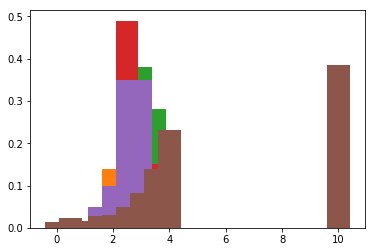

In [51]:
### Robustness checks: focus on big negative mean estimates 
sim_bins_data = SPF_bins
print(str(sum(IndSPF_pk['PRCCPIMean1']<-2))+' abnormals')
ct=0
figure=plt.plot()
for id in IndSPF_pk.index[IndSPF_pk['PRCCPIMean1']<-2]:
    print(id)
    print(IndSPF_pk['PRCCPIMean1'][id])
    sim_probs_data= np.flip(np.array([IndSPF['PRCCPI'+str(n)][id]/100 for n in range(11,21)]))
    plt.bar(sim_bins_data[1:],sim_probs_data)
    print(sim_probs_data)
    stats_est=SynDensityStat(SPF_bins,sim_probs_data)
    print(stats_est['mean'])